# Projekt Text minning
### Mateusz Chojnacki

### Wczytywanie potrzebnych bibliotek

In [1]:
# !pip install contractions
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# !pip install pyLDAvis
# !pip install textblob
# !pip install wordcloud
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

In [2]:
# Pomaga przy błędzie jeśli wystąpi przy chmurze słów.
# !jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import string
import contractions
import pickle
import pyLDAvis.sklearn

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
from string import digits


import matplotlib.pyplot as plt
import seaborn as sns

### Dane
Dane pochodzą z https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

Zestaw ten składa się z recenzji produktów spożywczych z Amazon.
- Dane obejmują okres ponad 10 lat, od 12 października 2012r.
- Recenzje obejmują informacje o produktach i użytkownikach, oceny oraz receznję w postaci zwykłego tekstu.
- Zawiera również recenzję ze wszystkich innych kategorii Amazon
- Zawiera około 500 000 recenzji, na potrzeby projektu oraz jego szybsze działanie wykorzystano 20 000.

### Wczytywanie danych

In [4]:
df = pd.read_csv('Reviews.csv', sep=',', nrows = 20000);
df.reset_index(drop=True, inplace=True);
print(df)

          Id   ProductId          UserId                      ProfileName  \
0          1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1          2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2          3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3          4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4          5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...      ...         ...             ...                              ...   
19995  19996  B002C50X1M  A1XRXZI5KOMVDD            KAF1958 "amandaf0626"   
19996  19997  B002C50X1M   A7G9M0IE7LABX                            Kevin   
19997  19998  B002C50X1M  A38J5PRUDESMZF                              ray   
19998  19999  B002C50X1M  A17TPOSAG43GSM                          Herrick   
19999  20000  B002C50X1M  A3LWC833HQIG7J                     austin_Larry   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0

### Wybranie odpowidnich kolumn
Jeśli skrypt odpalamy pierwszy raz należy odkomentować pierwsze 3 wiersze kodu.

In [5]:
# to_drop = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary']
# df.drop(to_drop, inplace = True, axis = 1)
# rws = df.loc[:, ['Score', 'Text']];

print(df)
rws = df

          Id   ProductId          UserId                      ProfileName  \
0          1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1          2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2          3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3          4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4          5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...      ...         ...             ...                              ...   
19995  19996  B002C50X1M  A1XRXZI5KOMVDD            KAF1958 "amandaf0626"   
19996  19997  B002C50X1M   A7G9M0IE7LABX                            Kevin   
19997  19998  B002C50X1M  A38J5PRUDESMZF                              ray   
19998  19999  B002C50X1M  A17TPOSAG43GSM                          Herrick   
19999  20000  B002C50X1M  A3LWC833HQIG7J                     austin_Larry   

       HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0

### Sprawdzanie czy nie istnieją u nas dane z pustymi rekordami.
Interesujące nas dane znajdują się tylko w kolumnach :
- Score
- Text

Jak widzimy nie występuje u nich brak danych.

In [6]:
for col in df.columns:
    print(col, df[col].isnull().sum())

Id 0
ProductId 0
UserId 0
ProfileName 0
HelpfulnessNumerator 0
HelpfulnessDenominator 0
Score 0
Time 0
Summary 0
Text 0


### Usuwanie angielskich skrótów

In [7]:
rws['no_contract'] = rws['Text'].apply(lambda x: [contractions.fix(word) for word in x.split()]);
rws['text_str'] = [' '.join(map(str, l)) for l in rws['no_contract']];
text_str = rws.text_str
print(text_str)

0        I have bought several of the Vitality canned d...
1        Product arrived labeled as Jumbo Salted Peanut...
2        This is a confection that has been around a fe...
3        If you are looking for the secret ingredient i...
4        Great taffy at a great price. There was a wide...
                               ...                        
19995    Deep River Salt & Vinegar chips are thick and ...
19996    I was very skeptical about buying a brand of c...
19997    Before you turn to other name brands out there...
19998    I was expecting some "serious flavor" as it wa...
19999    I purchased the Salt and Vinegar chips and hav...
Name: text_str, Length: 20000, dtype: object


### Czyszczenie tekstu
Nasza funkcja poniżej oczycza tekst w kolumnie "Text" za pomocą funkcji która :
- Usuwa znaki '...'
- Usuwa html
- Usuwa interpunkcje
- Przekształca na małe litery
- Usuwa słowa StopWords
- Usuwa inne wszystkie specjalne znaki

In [8]:
punc = string.punctuation;
stop_words = set(stopwords.words('english'));

def clean_text(data):
    data = data.apply(lambda x: [word.replace("...", "") for word in x.split()]);
    data = data.apply(lambda x: [word.replace('"', '') for word in x]);
    data = data.apply(lambda x: [re.sub(r'http\S+', '', word) for word in x]);
    data = data.apply(lambda x: [re.sub(r"\b\d+\b", "", word) for word in x]);
    data = data.apply(lambda x: [re.sub(r'[^\w]', ' ', word) for word in x]);
    data = data.apply(lambda x: [word.lower() for word in x]);
    data = data.apply(lambda x: [word for word in x if word not in punc]);
    data = data.apply(lambda x: [word for word in x if word not in stop_words]);
    data = data.apply(lambda x: [re.sub('[^A-Za-z0-9]+', '', word) for word in x]);
    return data
dane_final = clean_text(text_str)

train_data = dane_final
print(dane_final)

0        [bought, several, vitality, canned, dog, food,...
1        [product, arrived, labeled, jumbo, salted, pea...
2        [confection, around, centuries, light, pillowy...
3        [looking, secret, ingredient, robitussin, beli...
4        [great, taffy, great, price, wide, assortment,...
                               ...                        
19995    [deep, river, salt, , vinegar, chips, thick, c...
19996    [skeptical, buying, brand, chips, never, taste...
19997    [turn, name, brands, there, give, try, althoug...
19998    [expecting, serious, flavor, advertised, bag, ...
19999    [purchased, salt, vinegar, chips, pleased, rig...
Name: text_str, Length: 20000, dtype: object


### Stemmeing
Jest to sprowadzenie odmiennego słowa do jego rdzenia czyli w nie odmienionej formie.
W angielskich słowach będzie on ucinać takie przedrostki jak -ed -s -de -ize.

In [9]:
stemmer = SnowballStemmer("english")

rws['stemmed'] = dane_final.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
print(rws['stemmed'])

0        [bought, sever, vital, can, dog, food, product...
1        [product, arriv, label, jumbo, salt, peanutsth...
2        [confect, around, centuri, light, pillowi, cit...
3        [look, secret, ingredi, robitussin, believ, fo...
4        [great, taffi, great, price, wide, assort, yum...
                               ...                        
19995    [deep, river, salt, , vinegar, chip, thick, cr...
19996    [skeptic, buy, brand, chip, never, tast, befor...
19997    [turn, name, brand, there, give, tri, although...
19998    [expect, serious, flavor, advertis, bag, compa...
19999    [purchas, salt, vinegar, chip, pleas, right, a...
Name: stemmed, Length: 20000, dtype: object


### Lematyzacja
Jest to sprowadzenie grupy wyrazów, które stanowią odmianę danego słowa do wspólnej części, tak żeby można było je grupować.

In [10]:
rws['pos_tags'] = rws['stemmed'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
rws['wordnet_pos'] = rws['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
rws['lemmatized'] = rws['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
lemmatized = rws.lemmatized
print(lemmatized)

0        [buy, sever, vital, can, dog, food, product, f...
1        [product, arriv, label, jumbo, salt, peanutsth...
2        [confect, around, centuri, light, pillowi, cit...
3        [look, secret, ingredi, robitussin, believ, fi...
4        [great, taffi, great, price, wide, assort, yum...
                               ...                        
19995    [deep, river, salt, , vinegar, chip, thick, cr...
19996    [skeptic, buy, brand, chip, never, tast, befor...
19997    [turn, name, brand, there, give, tri, although...
19998    [expect, serious, flavor, advertis, bag, compa...
19999    [purchas, salt, vinegar, chip, pleas, right, a...
Name: lemmatized, Length: 20000, dtype: object


In [11]:
# Wybieramy naszą ocenę oraz oczyszczoną kolumnę
df = rws[['Score', 'lemmatized']]
print(df)

       Score                                         lemmatized
0          5  [buy, sever, vital, can, dog, food, product, f...
1          1  [product, arriv, label, jumbo, salt, peanutsth...
2          4  [confect, around, centuri, light, pillowi, cit...
3          2  [look, secret, ingredi, robitussin, believ, fi...
4          5  [great, taffi, great, price, wide, assort, yum...
...      ...                                                ...
19995      4  [deep, river, salt, , vinegar, chip, thick, cr...
19996      5  [skeptic, buy, brand, chip, never, tast, befor...
19997      5  [turn, name, brand, there, give, tri, although...
19998      3  [expect, serious, flavor, advertis, bag, compa...
19999      5  [purchas, salt, vinegar, chip, pleas, right, a...

[20000 rows x 2 columns]


### Analiza nastrojów
Służy ona do ocenienia postawy lub opinii pisarza w zakresie :
- -1 Bardzo negatywne nastawienie
-  1 Pozytywne nastawienie

Na początku trzeba dane przekształcić w ciąg.

In [12]:
pd.set_option('mode.chained_assignment', None)
df['lemma_str'] = [' '.join(map(str,l)) for l in df['lemmatized']]
print(df)

       Score                                         lemmatized  \
0          5  [buy, sever, vital, can, dog, food, product, f...   
1          1  [product, arriv, label, jumbo, salt, peanutsth...   
2          4  [confect, around, centuri, light, pillowi, cit...   
3          2  [look, secret, ingredi, robitussin, believ, fi...   
4          5  [great, taffi, great, price, wide, assort, yum...   
...      ...                                                ...   
19995      4  [deep, river, salt, , vinegar, chip, thick, cr...   
19996      5  [skeptic, buy, brand, chip, never, tast, befor...   
19997      5  [turn, name, brand, there, give, tri, although...   
19998      3  [expect, serious, flavor, advertis, bag, compa...   
19999      5  [purchas, salt, vinegar, chip, pleas, right, a...   

                                               lemma_str  
0      buy sever vital can dog food product find good...  
1      product arriv label jumbo salt peanutsth peanu...  
2      confect aro

In [13]:
df['sentiment'] = df['lemma_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_data = df.drop(columns = ['lemmatized', 'sentiment'])
df = df[['Score', 'lemmatized' ,'lemma_str', 'sentiment']]
print(df)

       Score                                         lemmatized  \
0          5  [buy, sever, vital, can, dog, food, product, f...   
1          1  [product, arriv, label, jumbo, salt, peanutsth...   
2          4  [confect, around, centuri, light, pillowi, cit...   
3          2  [look, secret, ingredi, robitussin, believ, fi...   
4          5  [great, taffi, great, price, wide, assort, yum...   
...      ...                                                ...   
19995      4  [deep, river, salt, , vinegar, chip, thick, cr...   
19996      5  [skeptic, buy, brand, chip, never, tast, befor...   
19997      5  [turn, name, brand, there, give, tri, although...   
19998      3  [expect, serious, flavor, advertis, bag, compa...   
19999      5  [purchas, salt, vinegar, chip, pleas, right, a...   

                                               lemma_str  sentiment  
0      buy sever vital can dog food product find good...   0.500000  
1      product arriv label jumbo salt peanutsth peanu..

Jak można zauważyć wartość 'sentiment' jest tym wyższa im wyższa jest ocena (Score) wskazana przez użytkownika.
Z definicji możemy więc stwierdzić że analiza nastrojów w tym przypadku działa zadowalająco dobrze ponieważ wartość
sentymentu dla Score = 5 jest wyższa niż dla Score = 1.

Poniżej jeszcze dokładniej to zaoobserwowujemy na wykresie.

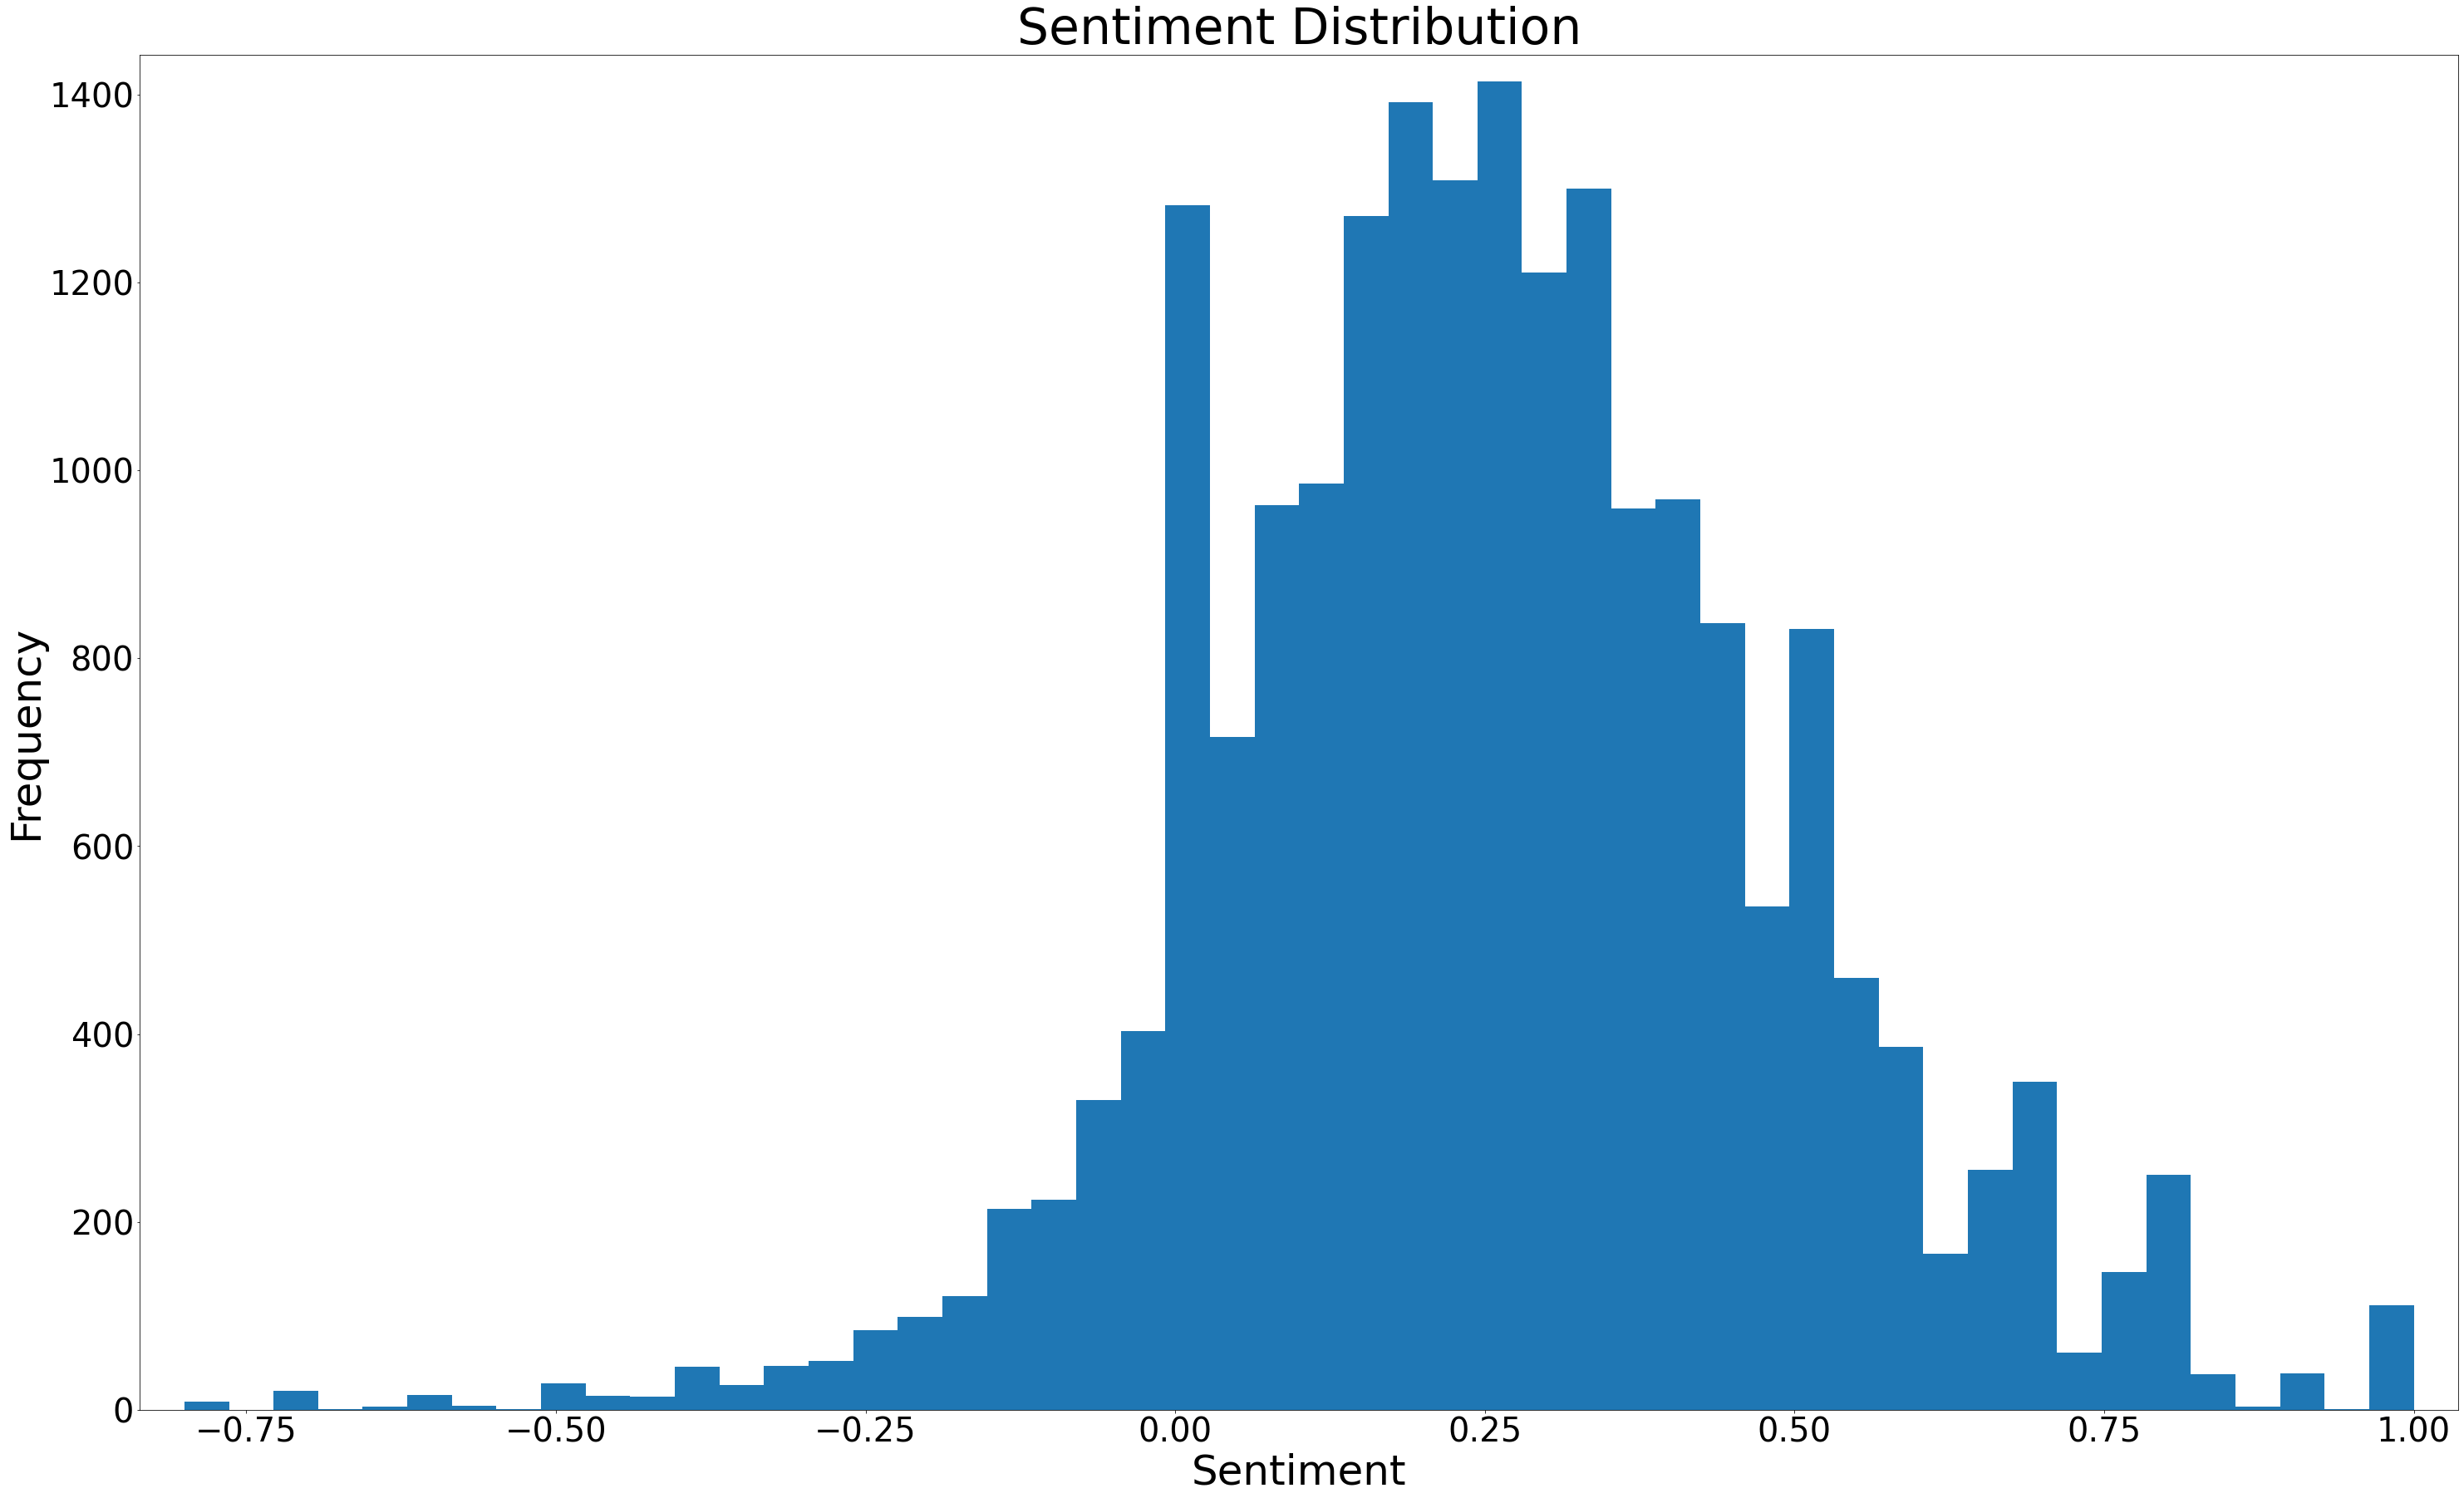

In [14]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

Wykres po wyżej mówi nam że możemy stwierdzić że o wiele więcej jest opnii pozytywnych w naszej próbce.

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

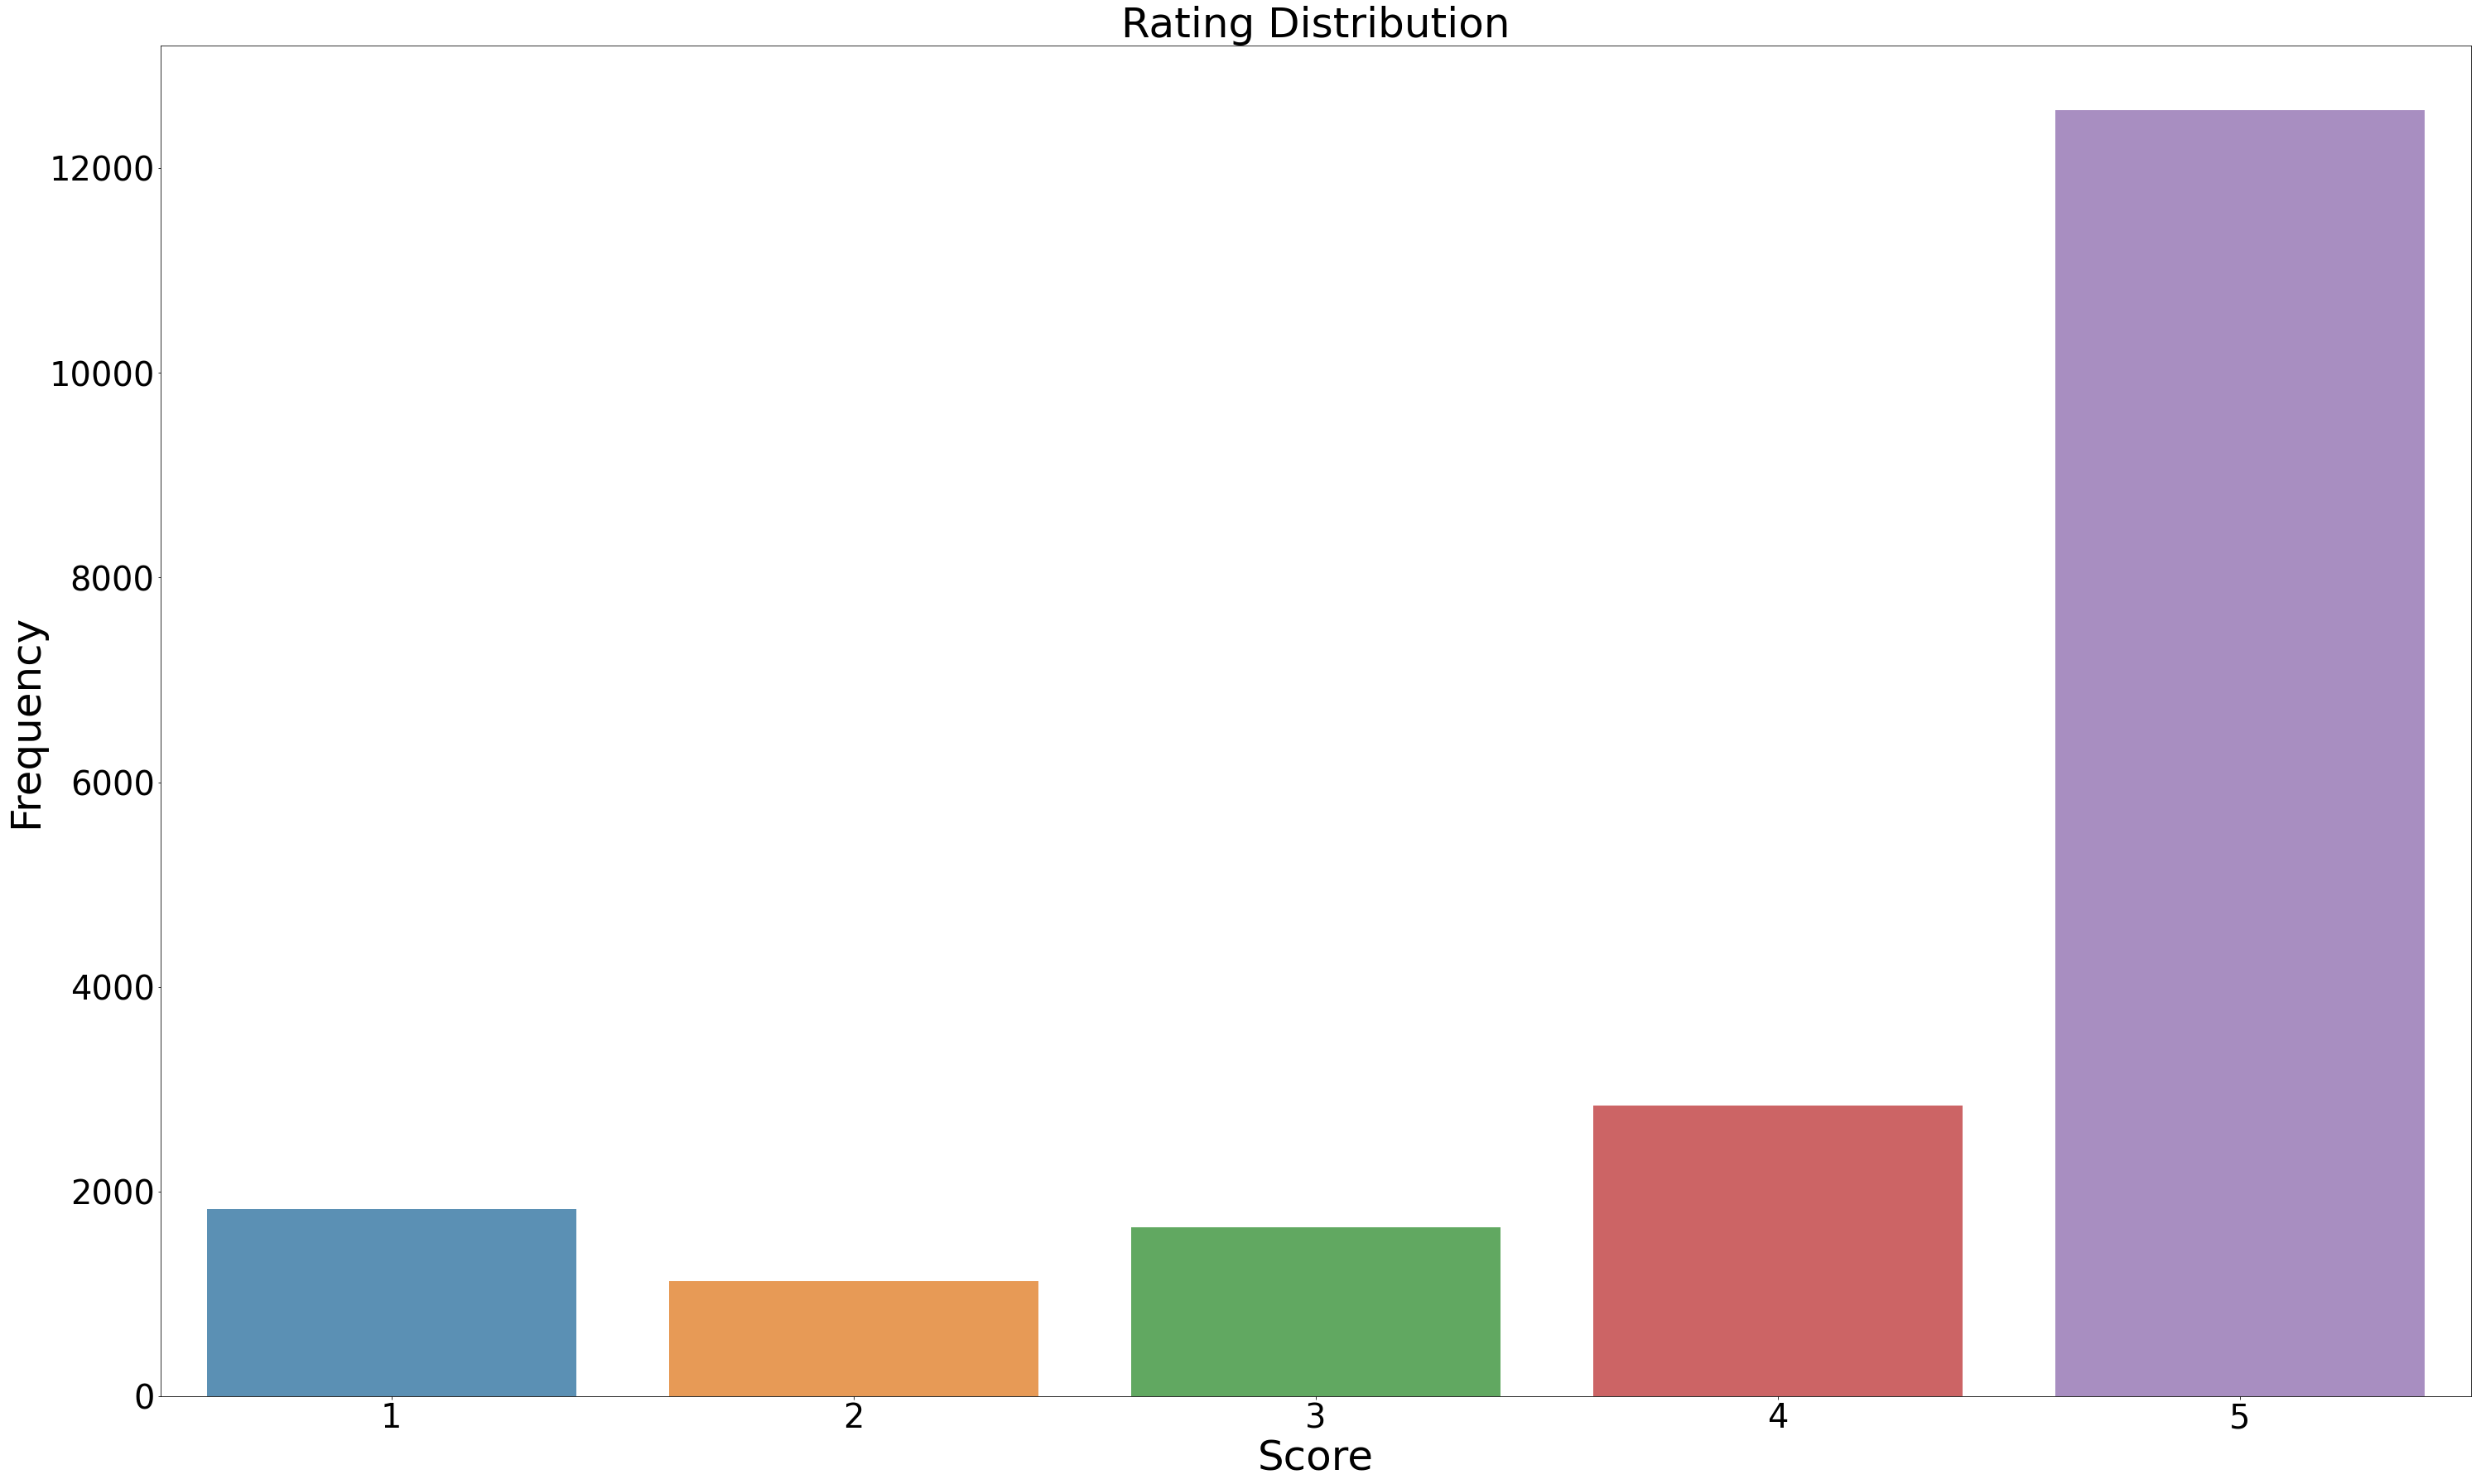

In [15]:
x_score = df.Score.value_counts()
y_score = x_score.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(x_score.index, x_score.values, alpha=0.8)
plt.title("Rating Distribution", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Score', fontsize=50)
plt.xticks(fontsize=40)

<AxesSubplot:title={'center':'Percentage of Score'}, ylabel='Score'>

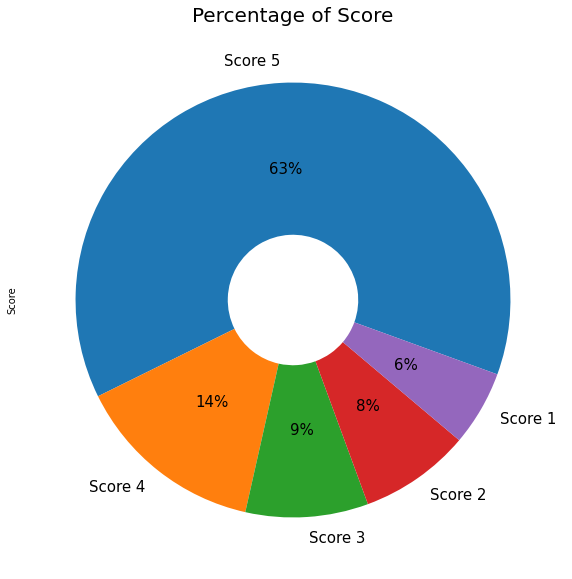

In [16]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Score', fontsize=20)
df.Score.value_counts().plot(kind='pie', labels=['Score 5', 'Score 4', 'Score 3', 'Score 2', 'Score 1'],
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})

Na wykresie 'Avarge Sentiment per Score Distribution' możemy zauważyć dokładną średnią sentimentu dla każdego Score.

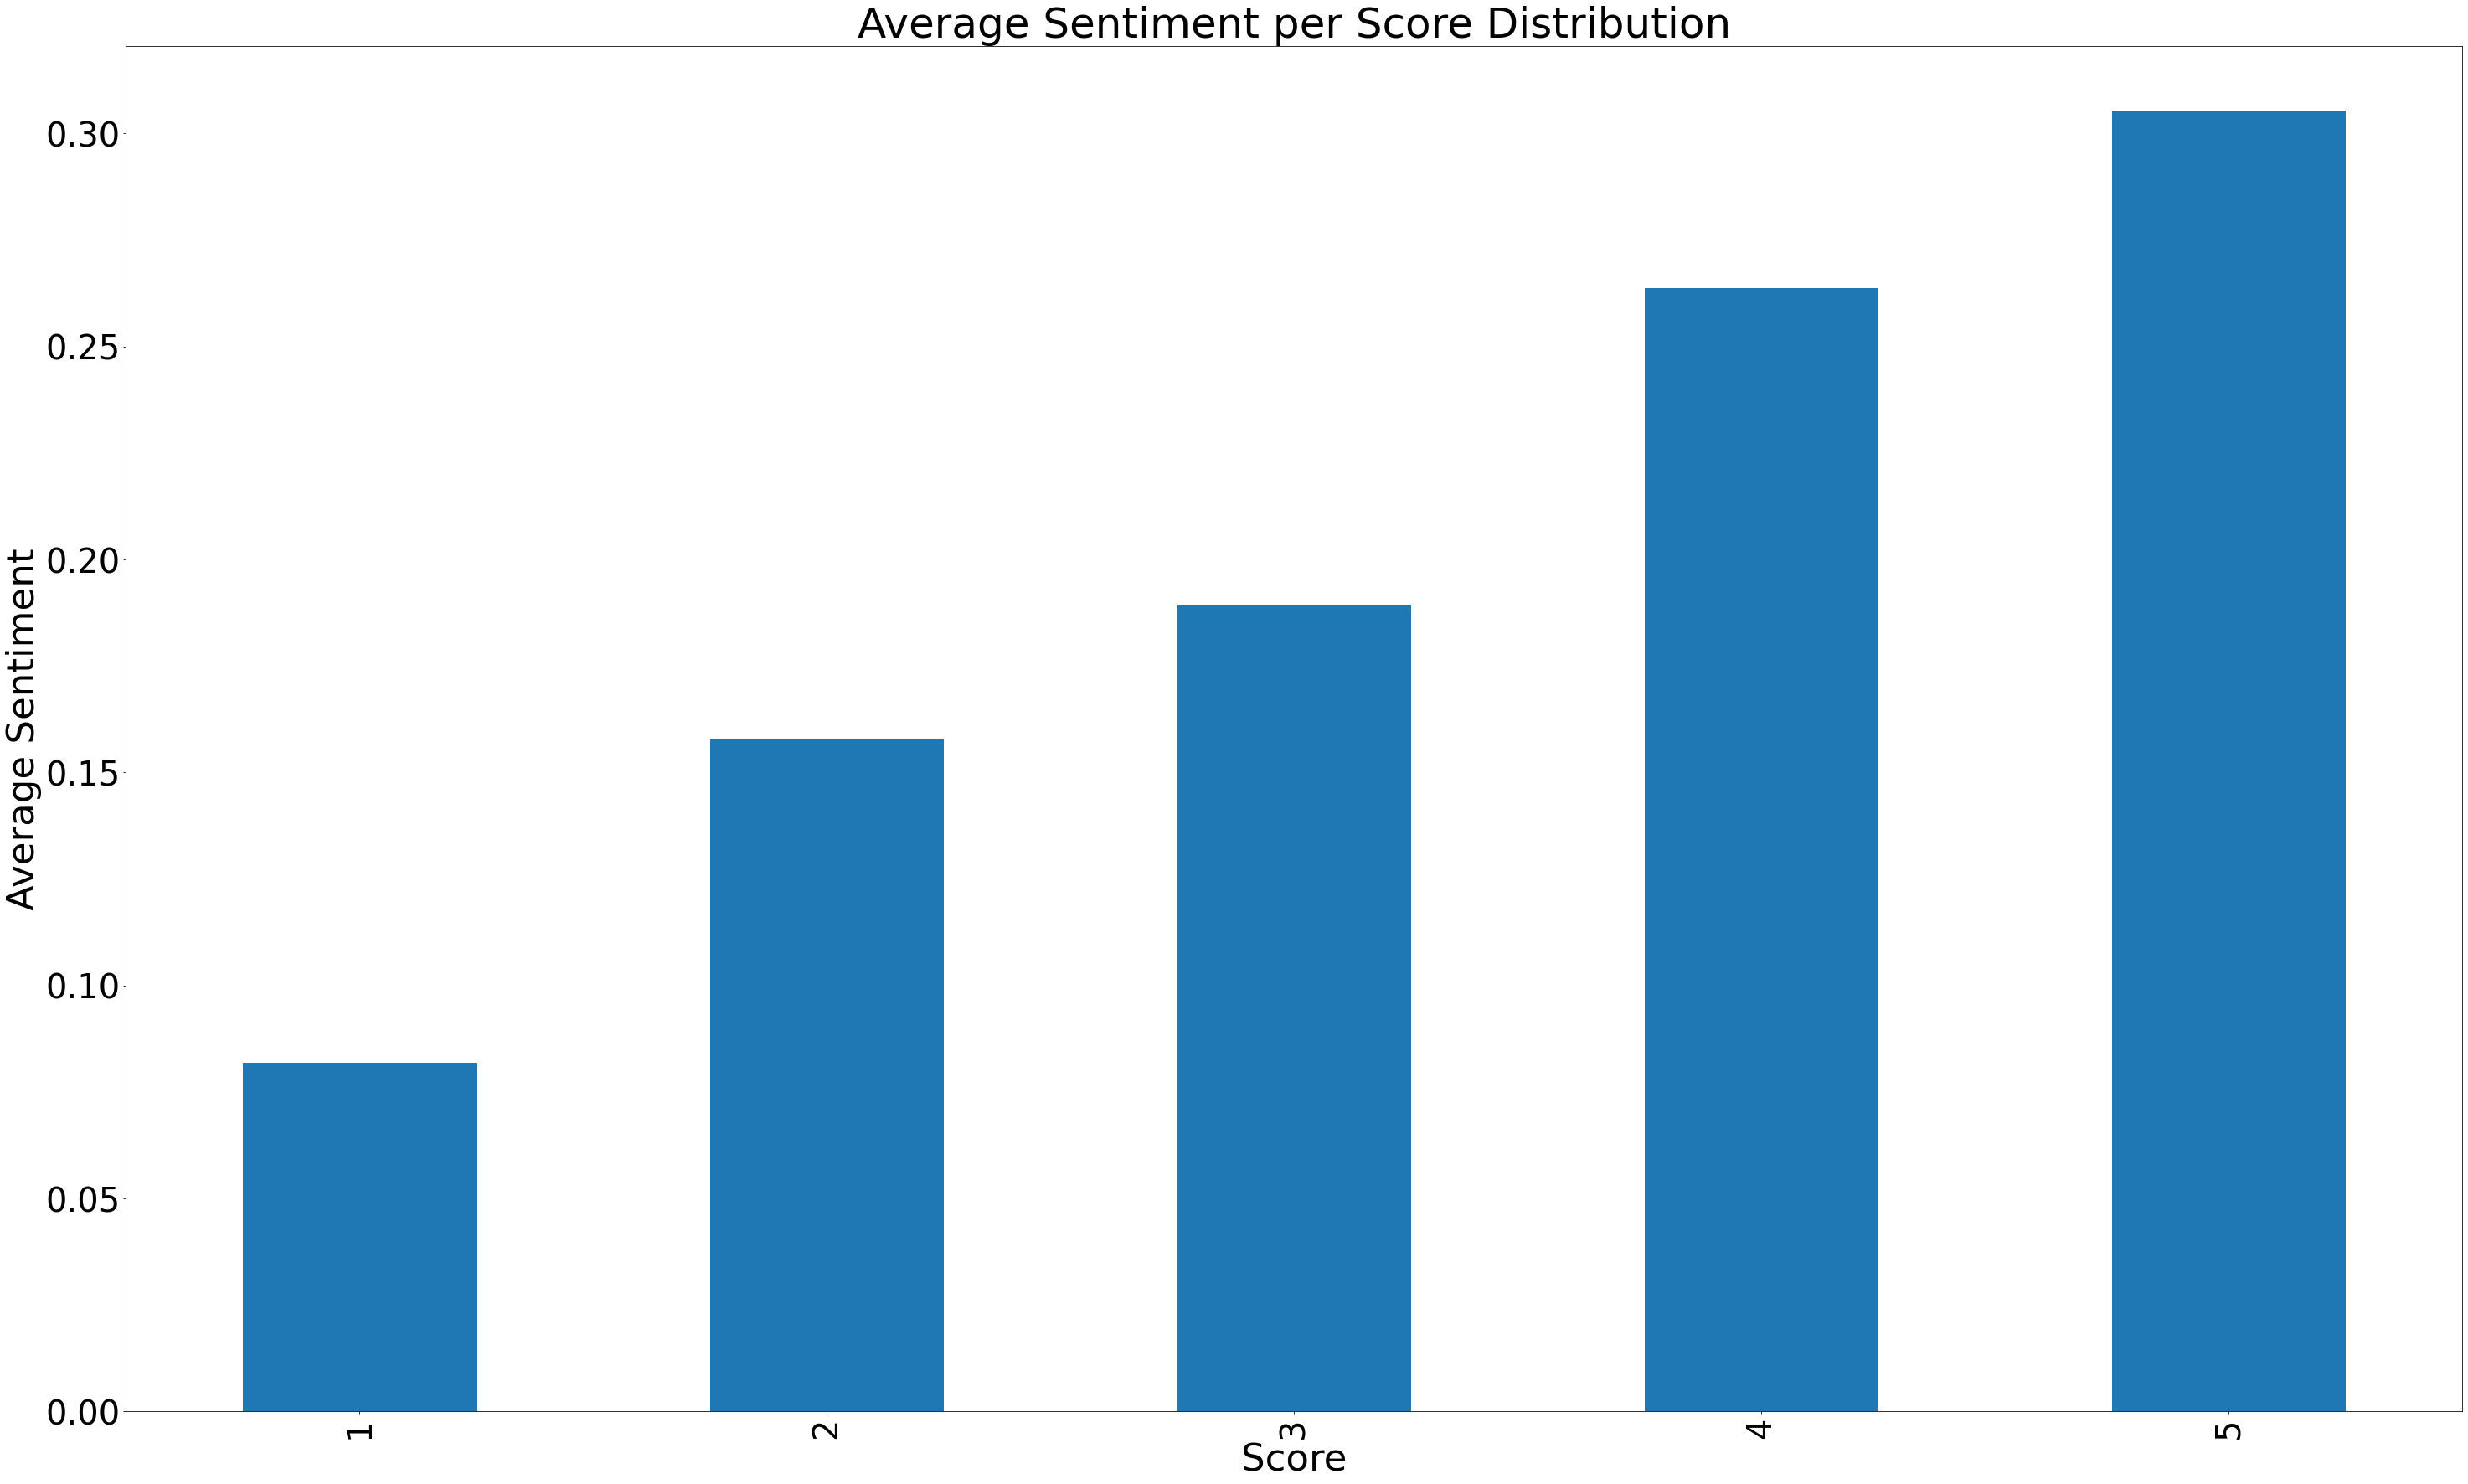

In [17]:
polarity_avg = df.groupby('Score')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Score', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Score Distribution', fontsize=50)
plt.show()

### Chmura słów

Wykorzystane narzędzia skutkują utworzenia chmury słów.

W tej części proejktu zajmiemy się :

- Wszystkie słowa jakie występują w próbce
- Top 100 graficznie przedstawionych słów
- Najwięcej słów występujących w poszczególnych Score

In [18]:
words = df['lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist

# words = allwords
stopwords = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'br', 'it', 'tri']
# for word in list(allwords):  # iterating on a copy since removing will mess things up
#     if word in stopwords:
#         allwords.remove(word)

new_words = list(filter(lambda w: w not in stopwords, allwords))
print(new_words)

['buy', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'find', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'good', 'labrador', 'finicki', 'appreci', 'product', 'well', 'most', 'product', 'arriv', 'label', 'jumbo', 'salt', 'peanutsth', 'peanut', 'actual', 'small', 'size', 'unsalt', 'sure', 'error', 'vendor', 'intend', 'repres', 'product', 'jumbo', 'confect', 'around', 'centuri', 'light', 'pillowi', 'citrus', 'gelatin', 'nut', '', 'case', 'filbert', 'cut', 'tini', 'squar', 'liber', 'coat', 'powder', 'sugar', 'tini', 'mouth', 'heaven', 'chewi', 'flavor', 'high', 'recommend', 'yummi', 'treat', 'familiar', 'stori', 'lewi', 'lion', 'witch', 'wardrob', '', 'treat', 'seduc', 'edmund', 'sell', 'brother', 'sister', 'witch', 'look', 'secret', 'ingredi', 'robitussin', 'believ', 'find', 'get', 'addit', 'root', 'beer', 'extract', 'order', 'which', 'good', 'make', 'cherri', 'soda', 'flavor', 'medicin', 'great', 'taffi', 'great', 'price', 'wide', 'assort', 'yu

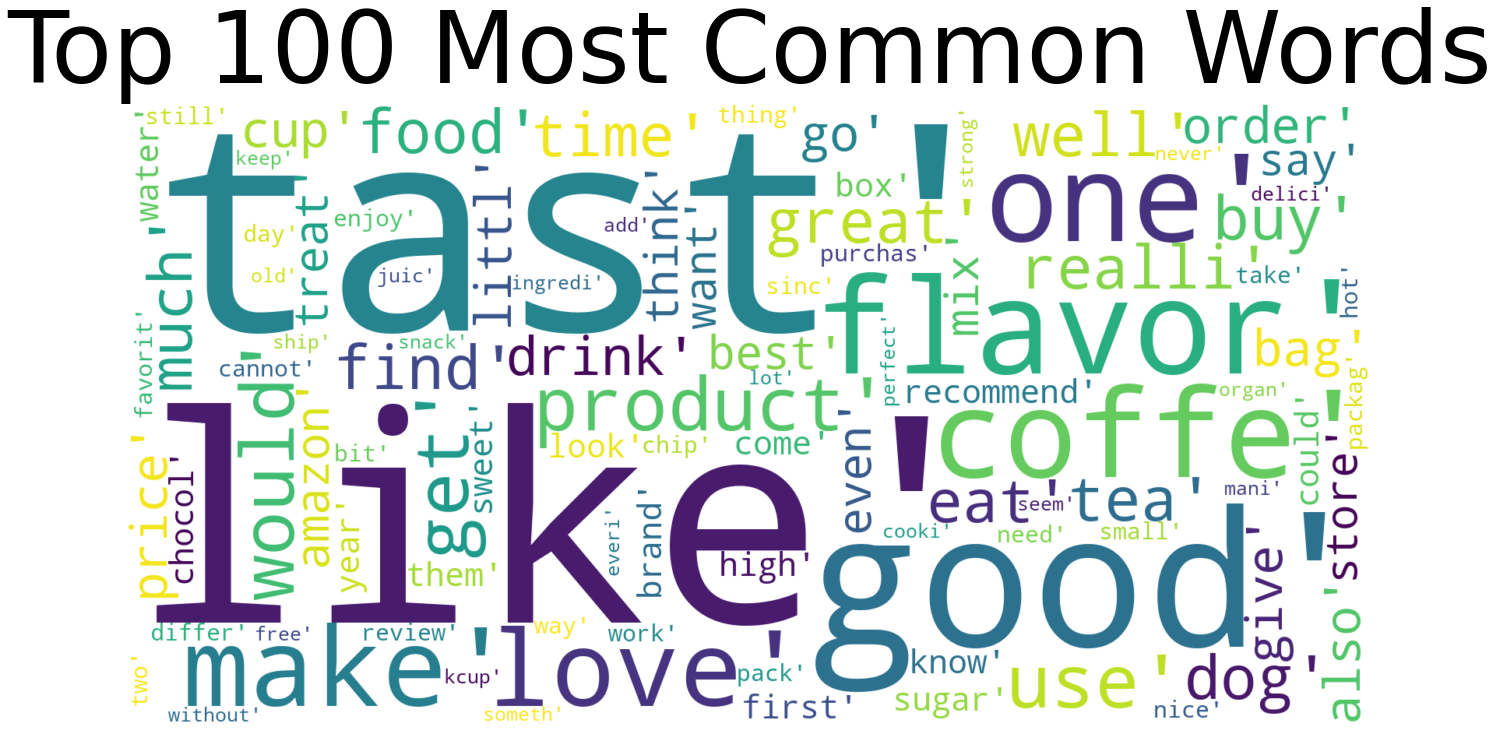

In [19]:
mostcommon = FreqDist(new_words).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

Wykresy z najczęściej wykorzystywanymi słowami w każdym Score
Warto zwrócić uwagę na Score gdzie jest bardzo przewazająca ilość słów pozytywnych typu : love, flavor, good itp.

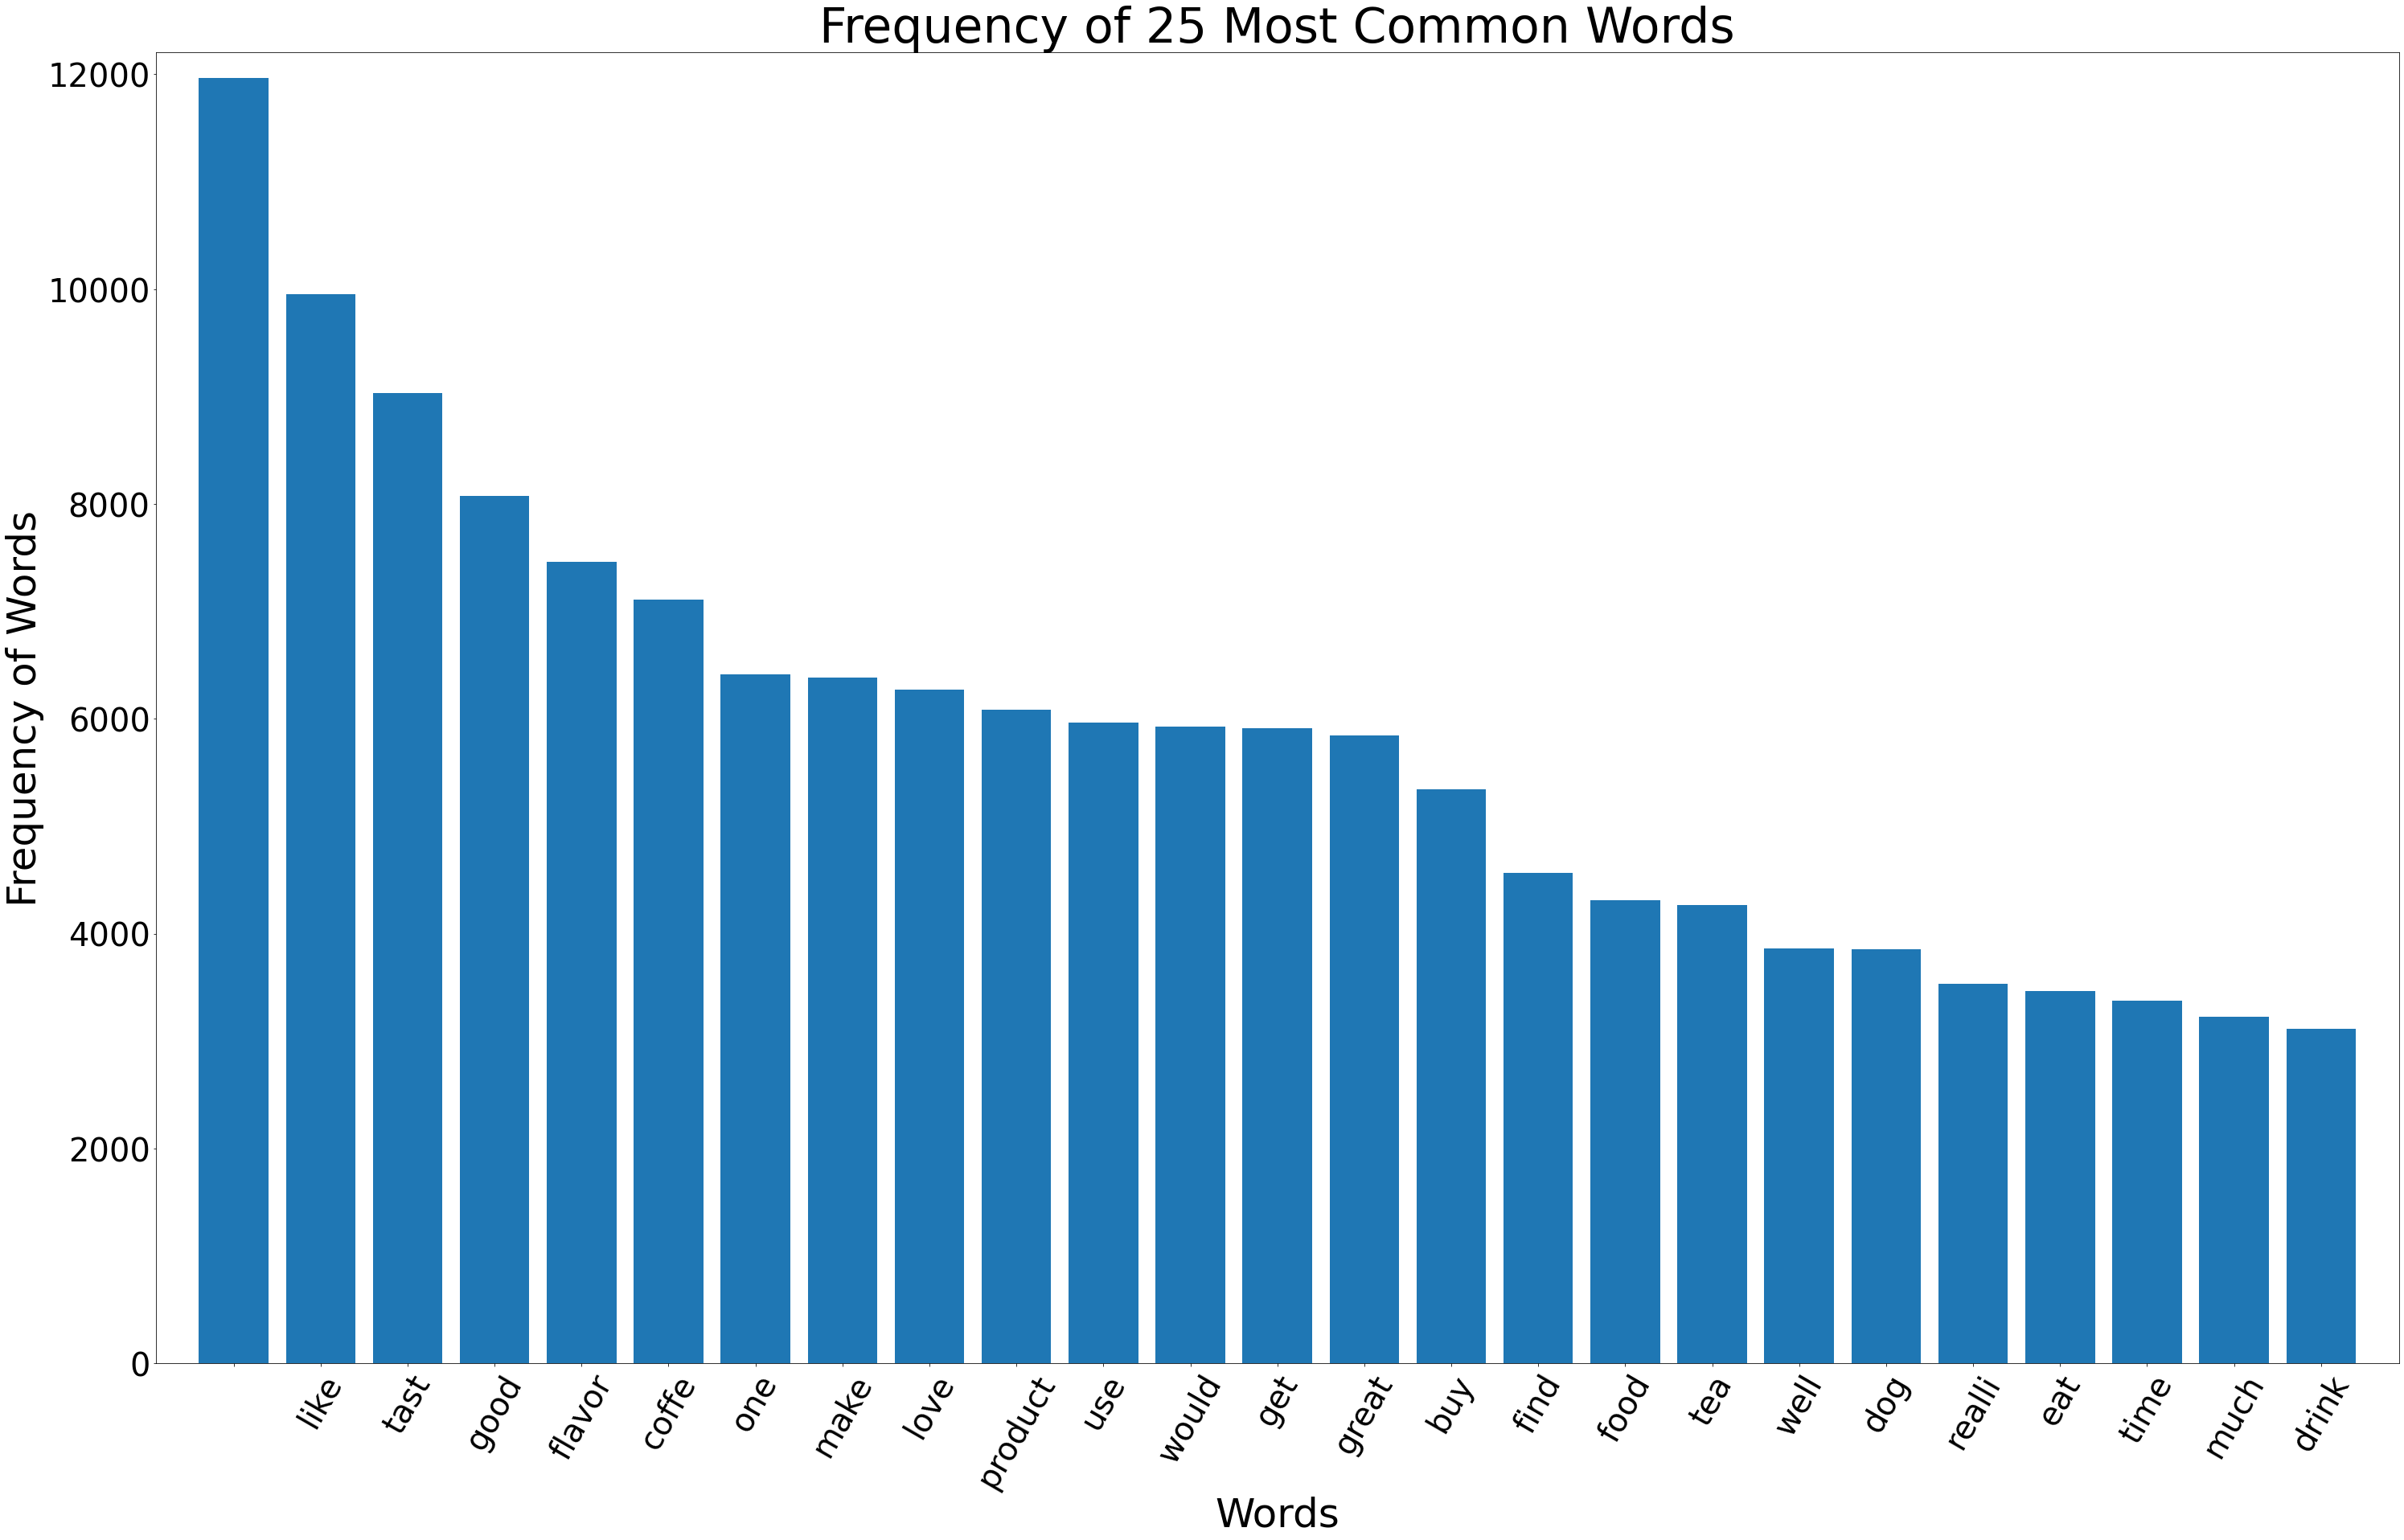

In [20]:
mostcommon_small = FreqDist(new_words).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

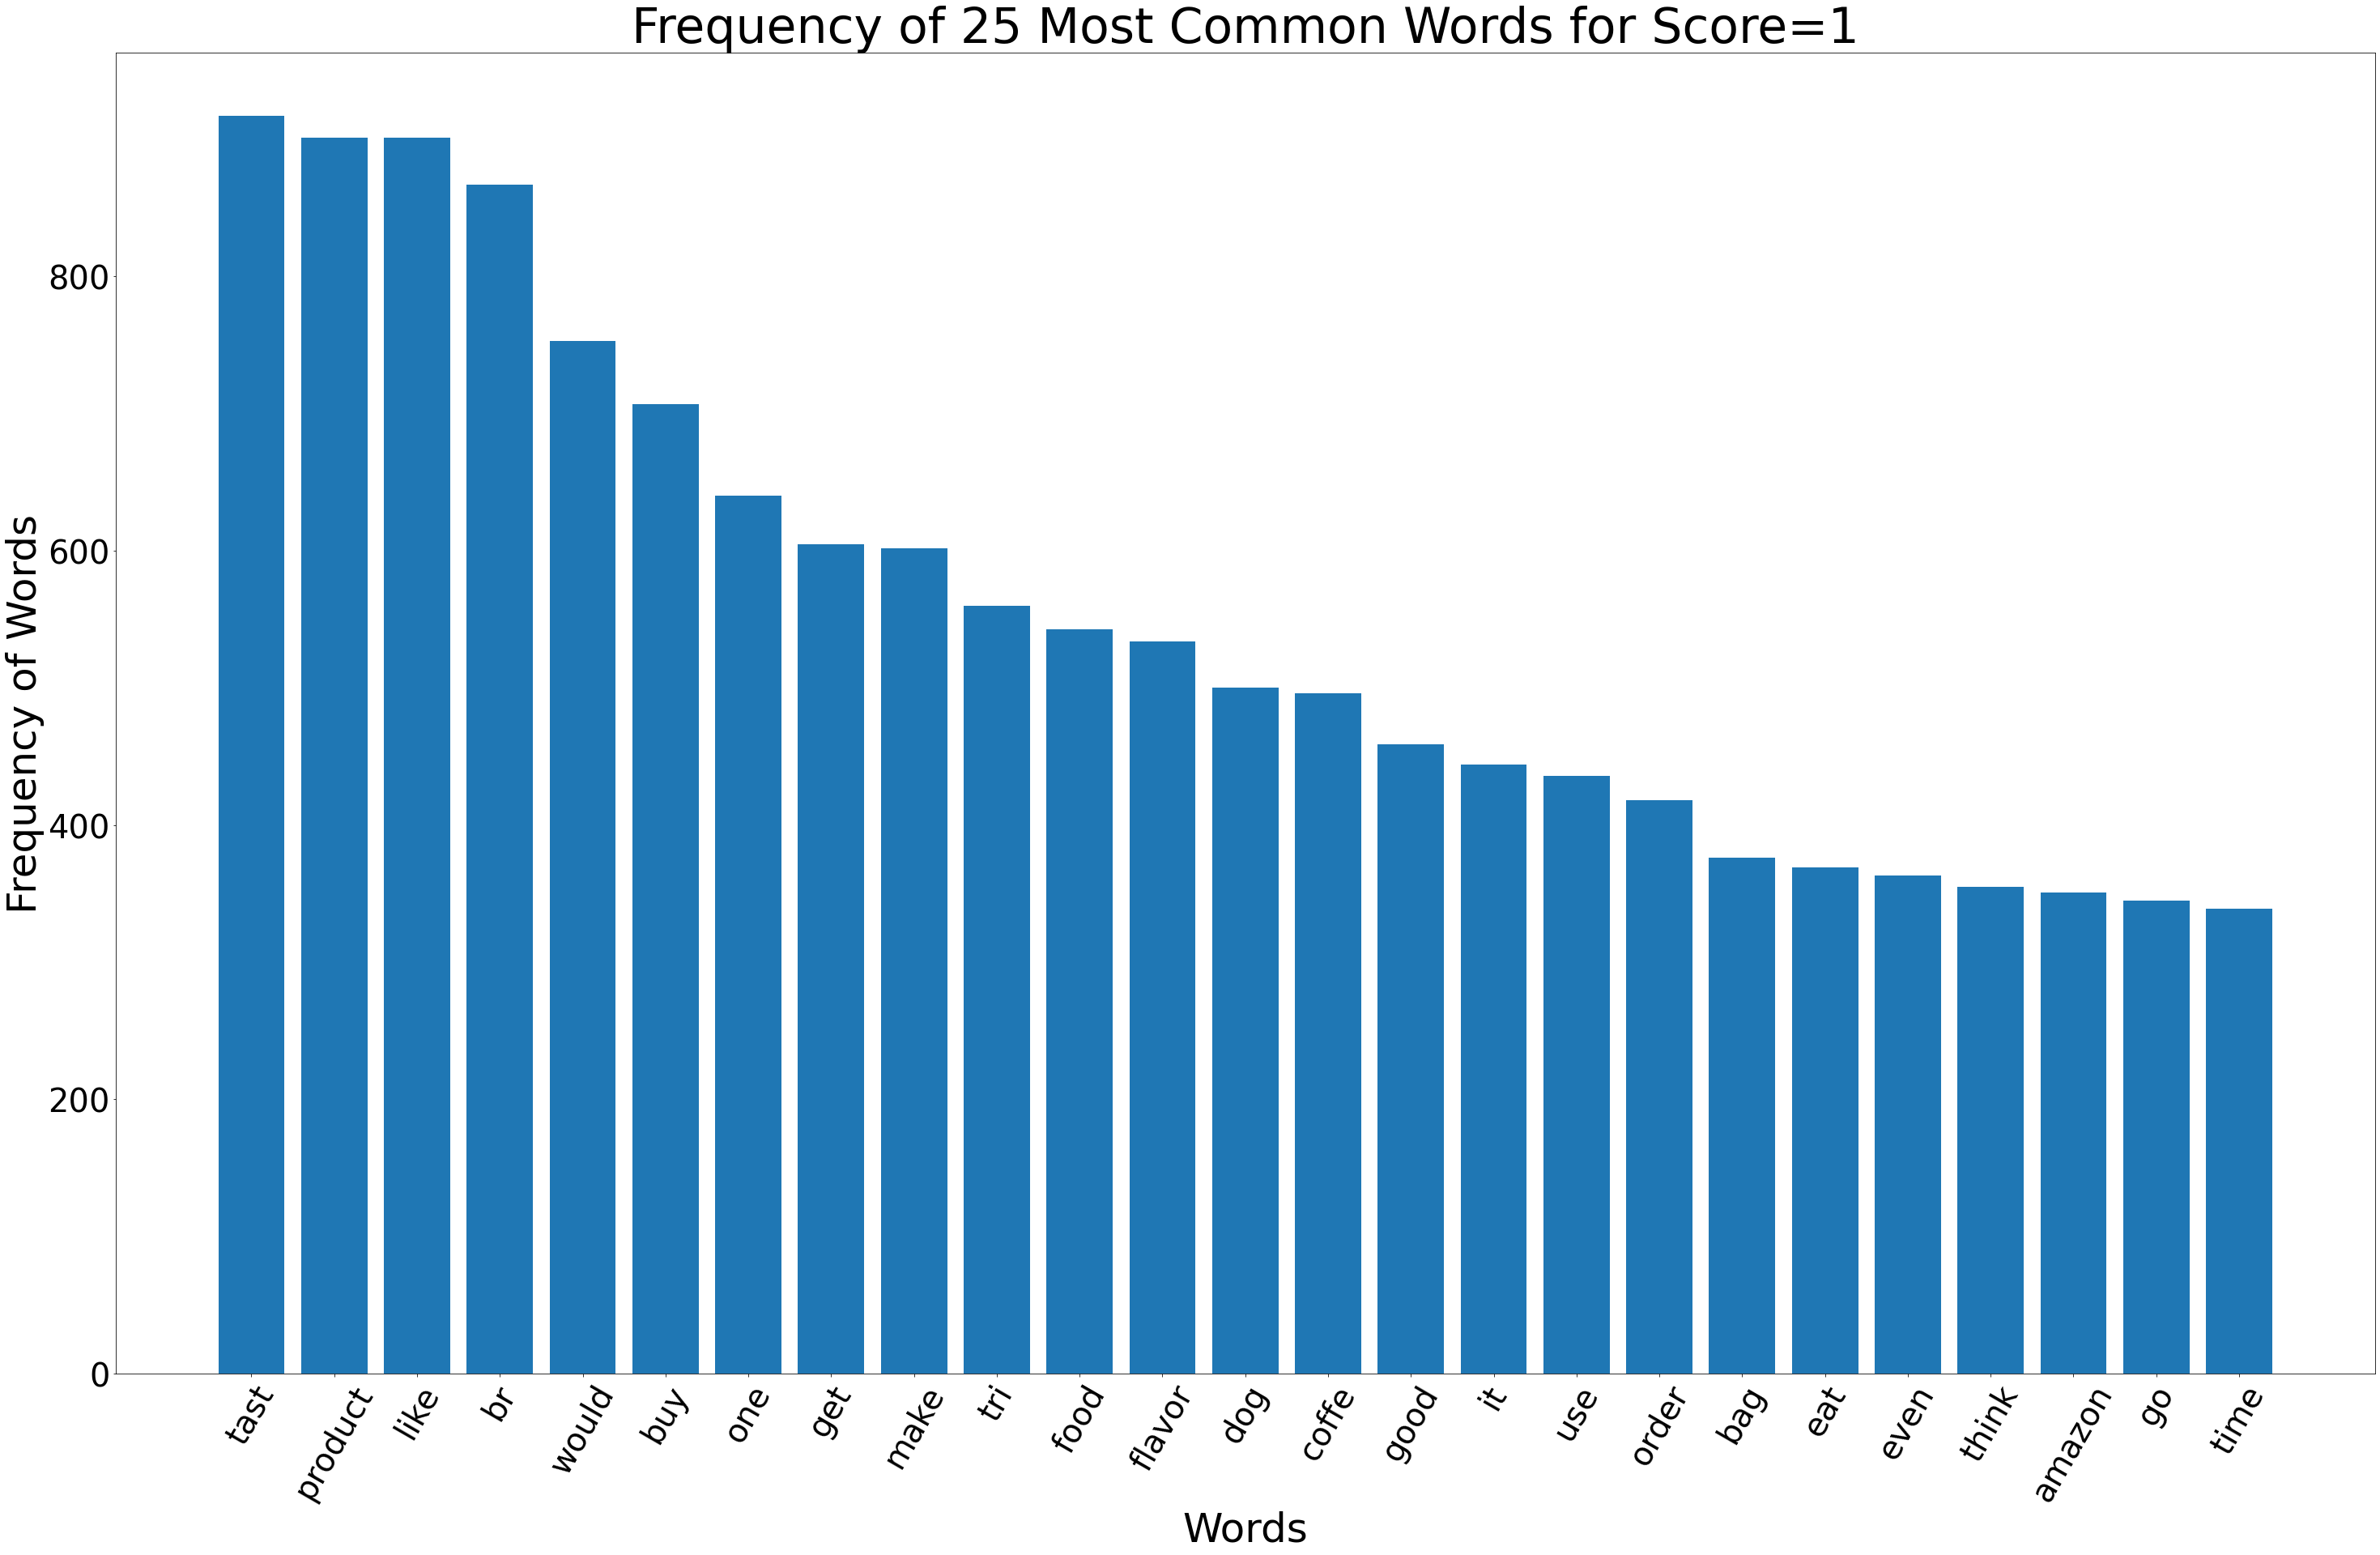

In [21]:
group_by = df.groupby('Score')['lemma_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))
group_by_0 = group_by.iloc[0]
words0 = list(zip(*group_by_0))[0]
freq0 = list(zip(*group_by_0))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=1', fontsize=60)
plt.show()

Dla Score 1 duża ilość jest słów :
- product
- like
- taste
- would

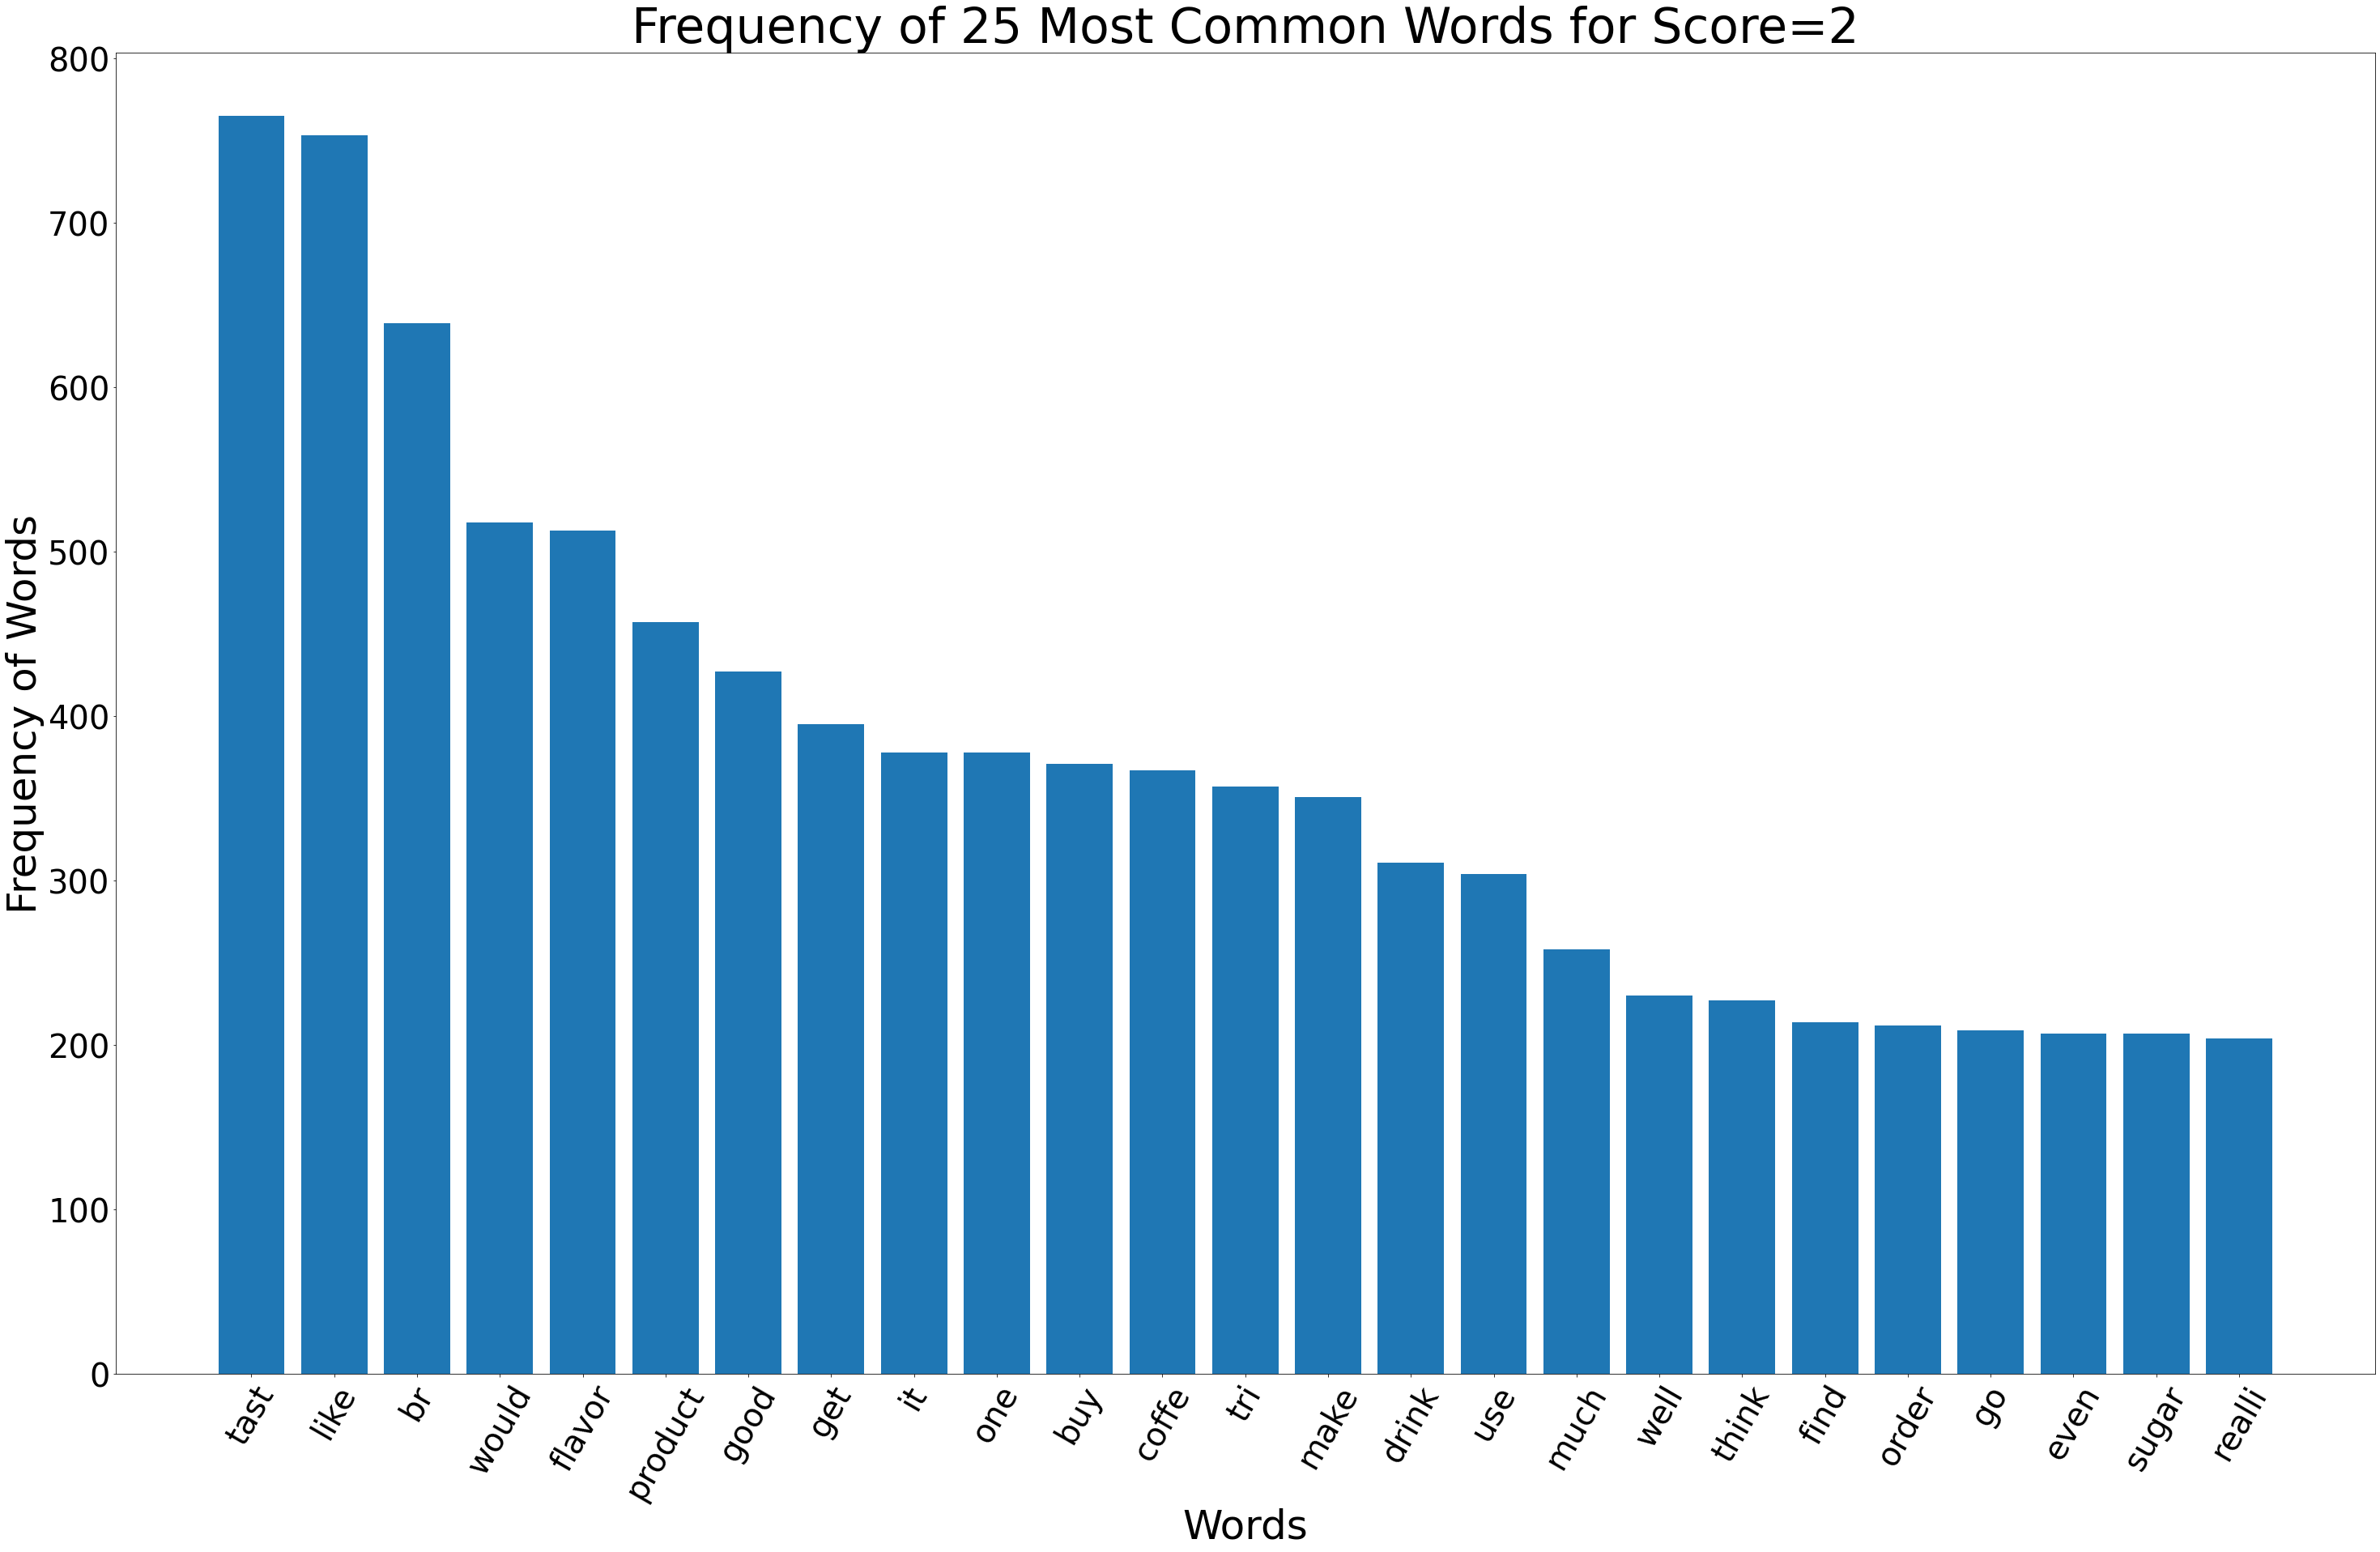

In [22]:
group_by_1 = group_by.iloc[1]
words1 = list(zip(*group_by_1))[0]
freq1 = list(zip(*group_by_1))[1]
plt.figure(figsize=(50,30))
plt.bar(words1, freq1)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=2', fontsize=60)
plt.show()

Dla Score 2 duża ilość jest słów :
- taste
- like
- flavor
- would

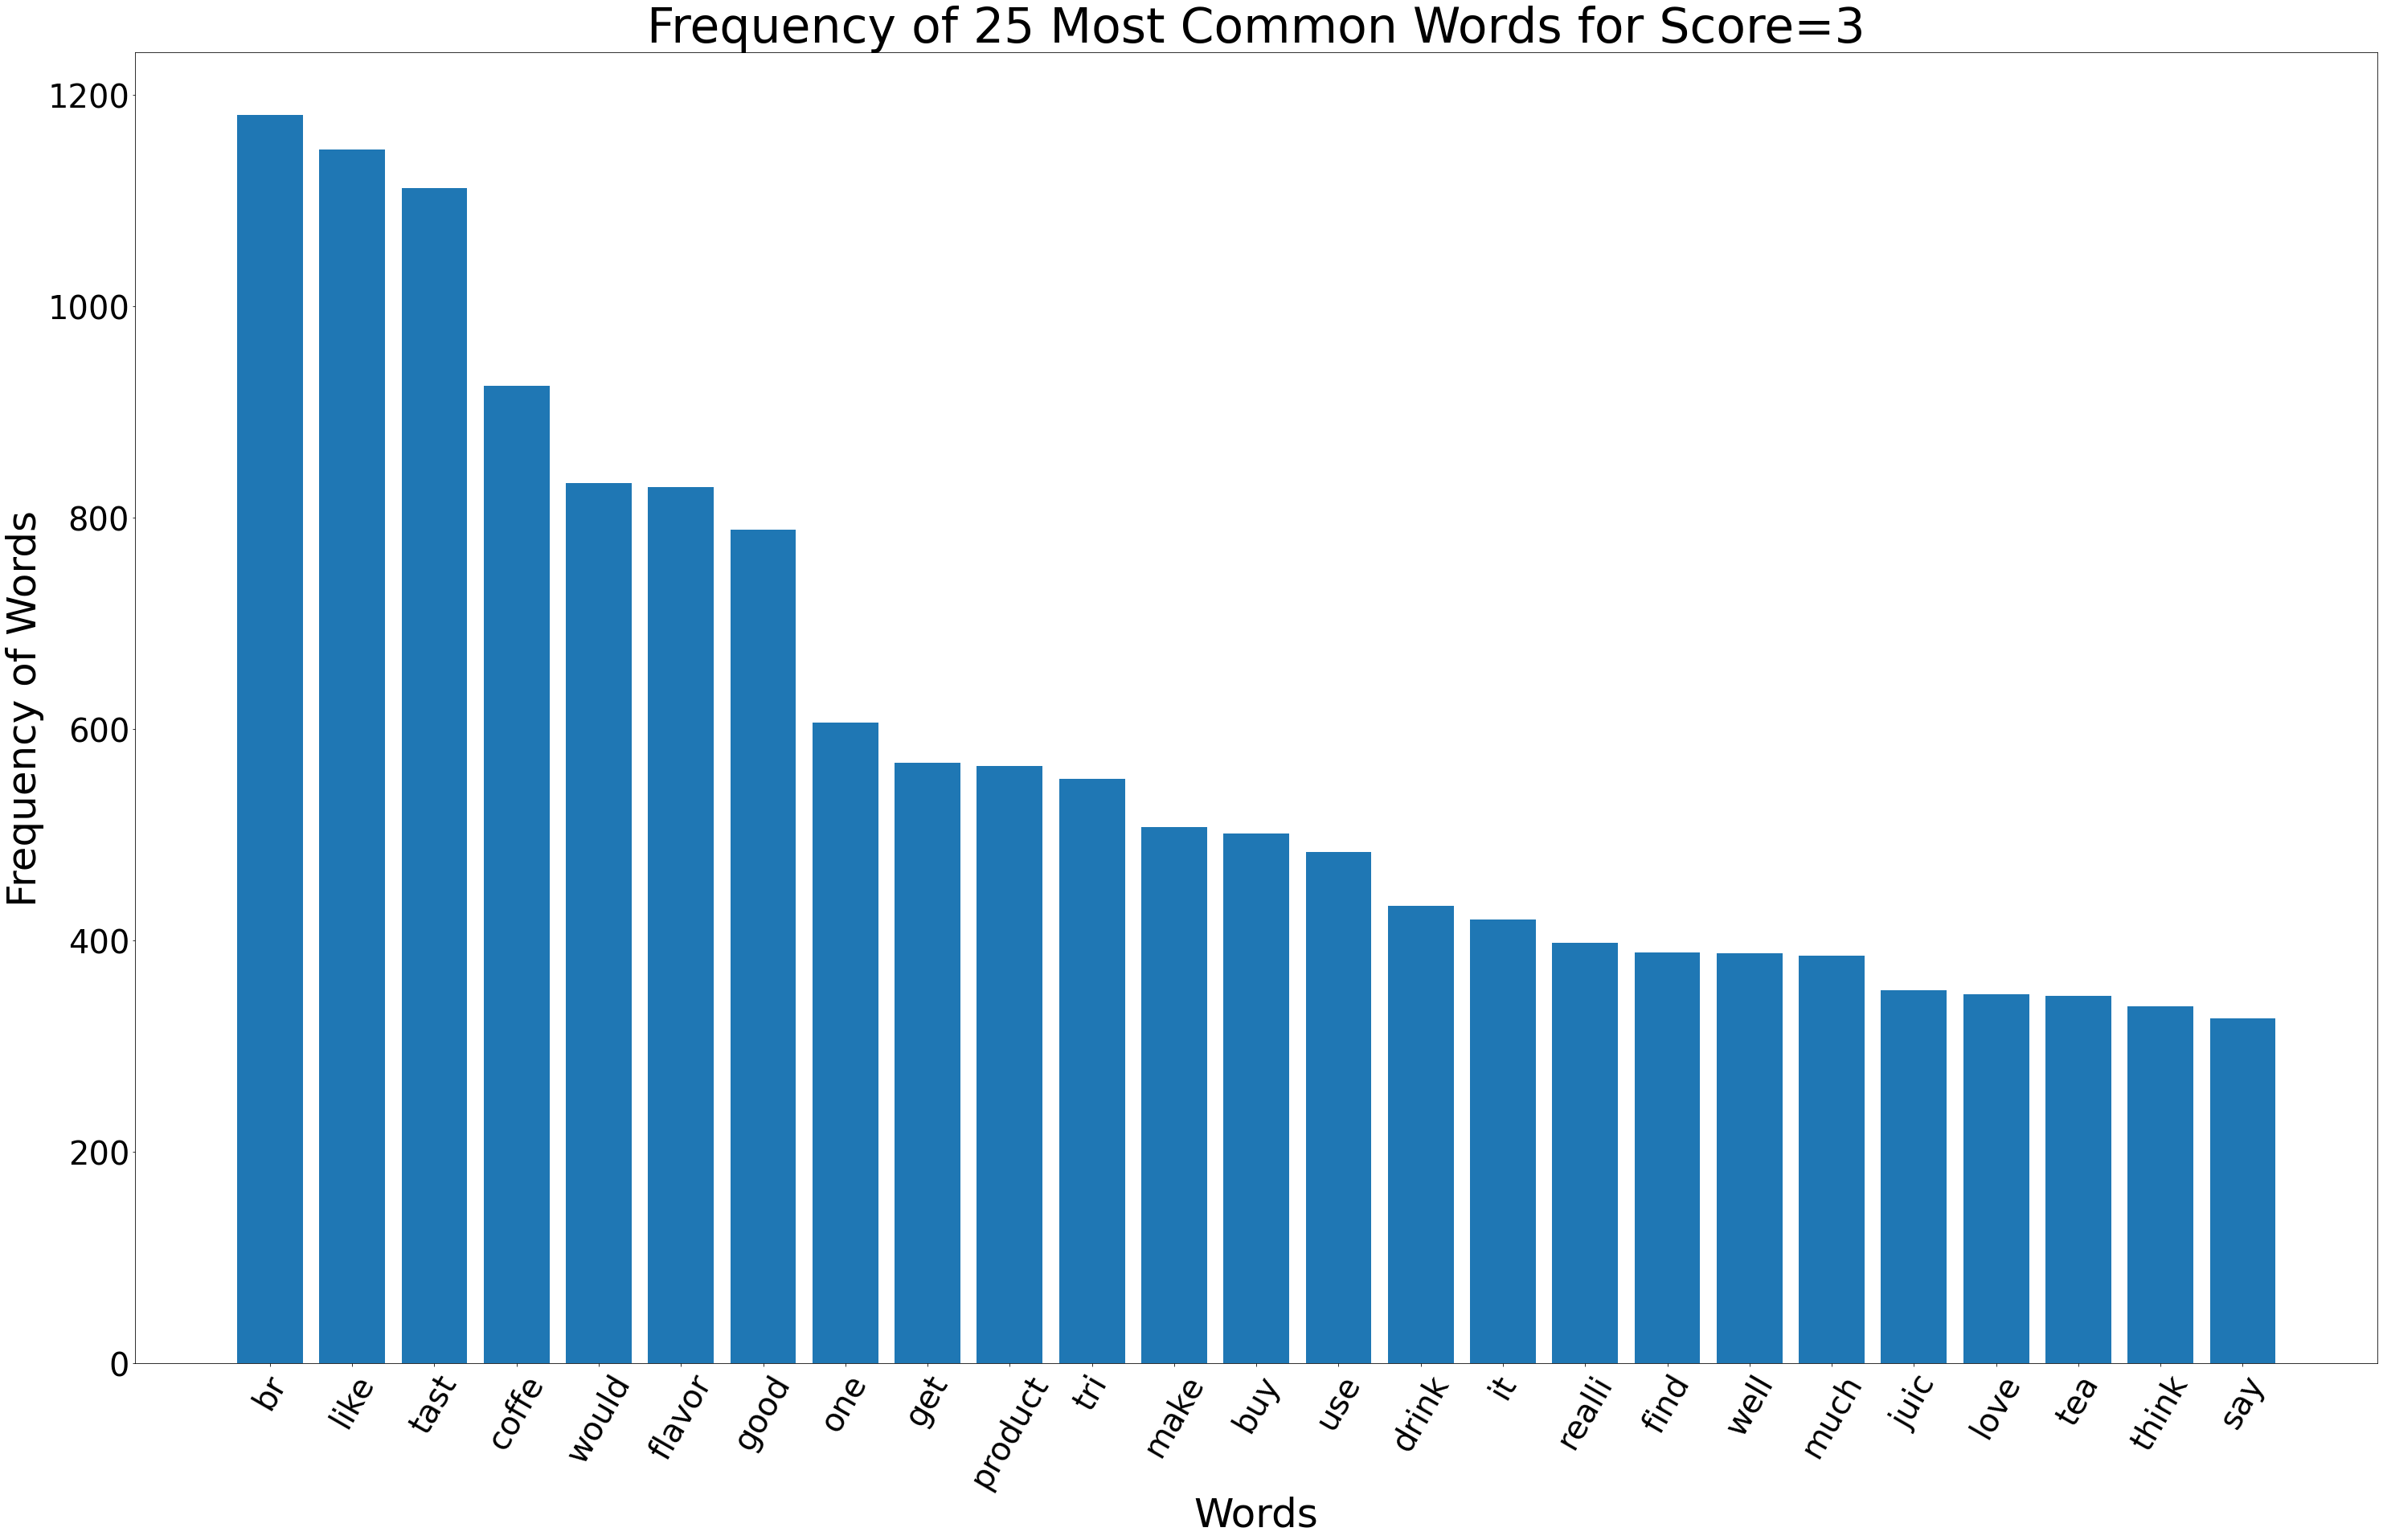

In [23]:
group_by_2 = group_by.iloc[2]
words2 = list(zip(*group_by_2))[0]
freq2 = list(zip(*group_by_2))[1]
plt.figure(figsize=(50,30))
plt.bar(words2, freq2)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=3', fontsize=60)
plt.show()

Dla Score 3 duża ilość jest słów :
- like
- taste
- coffe
- flavor
- good

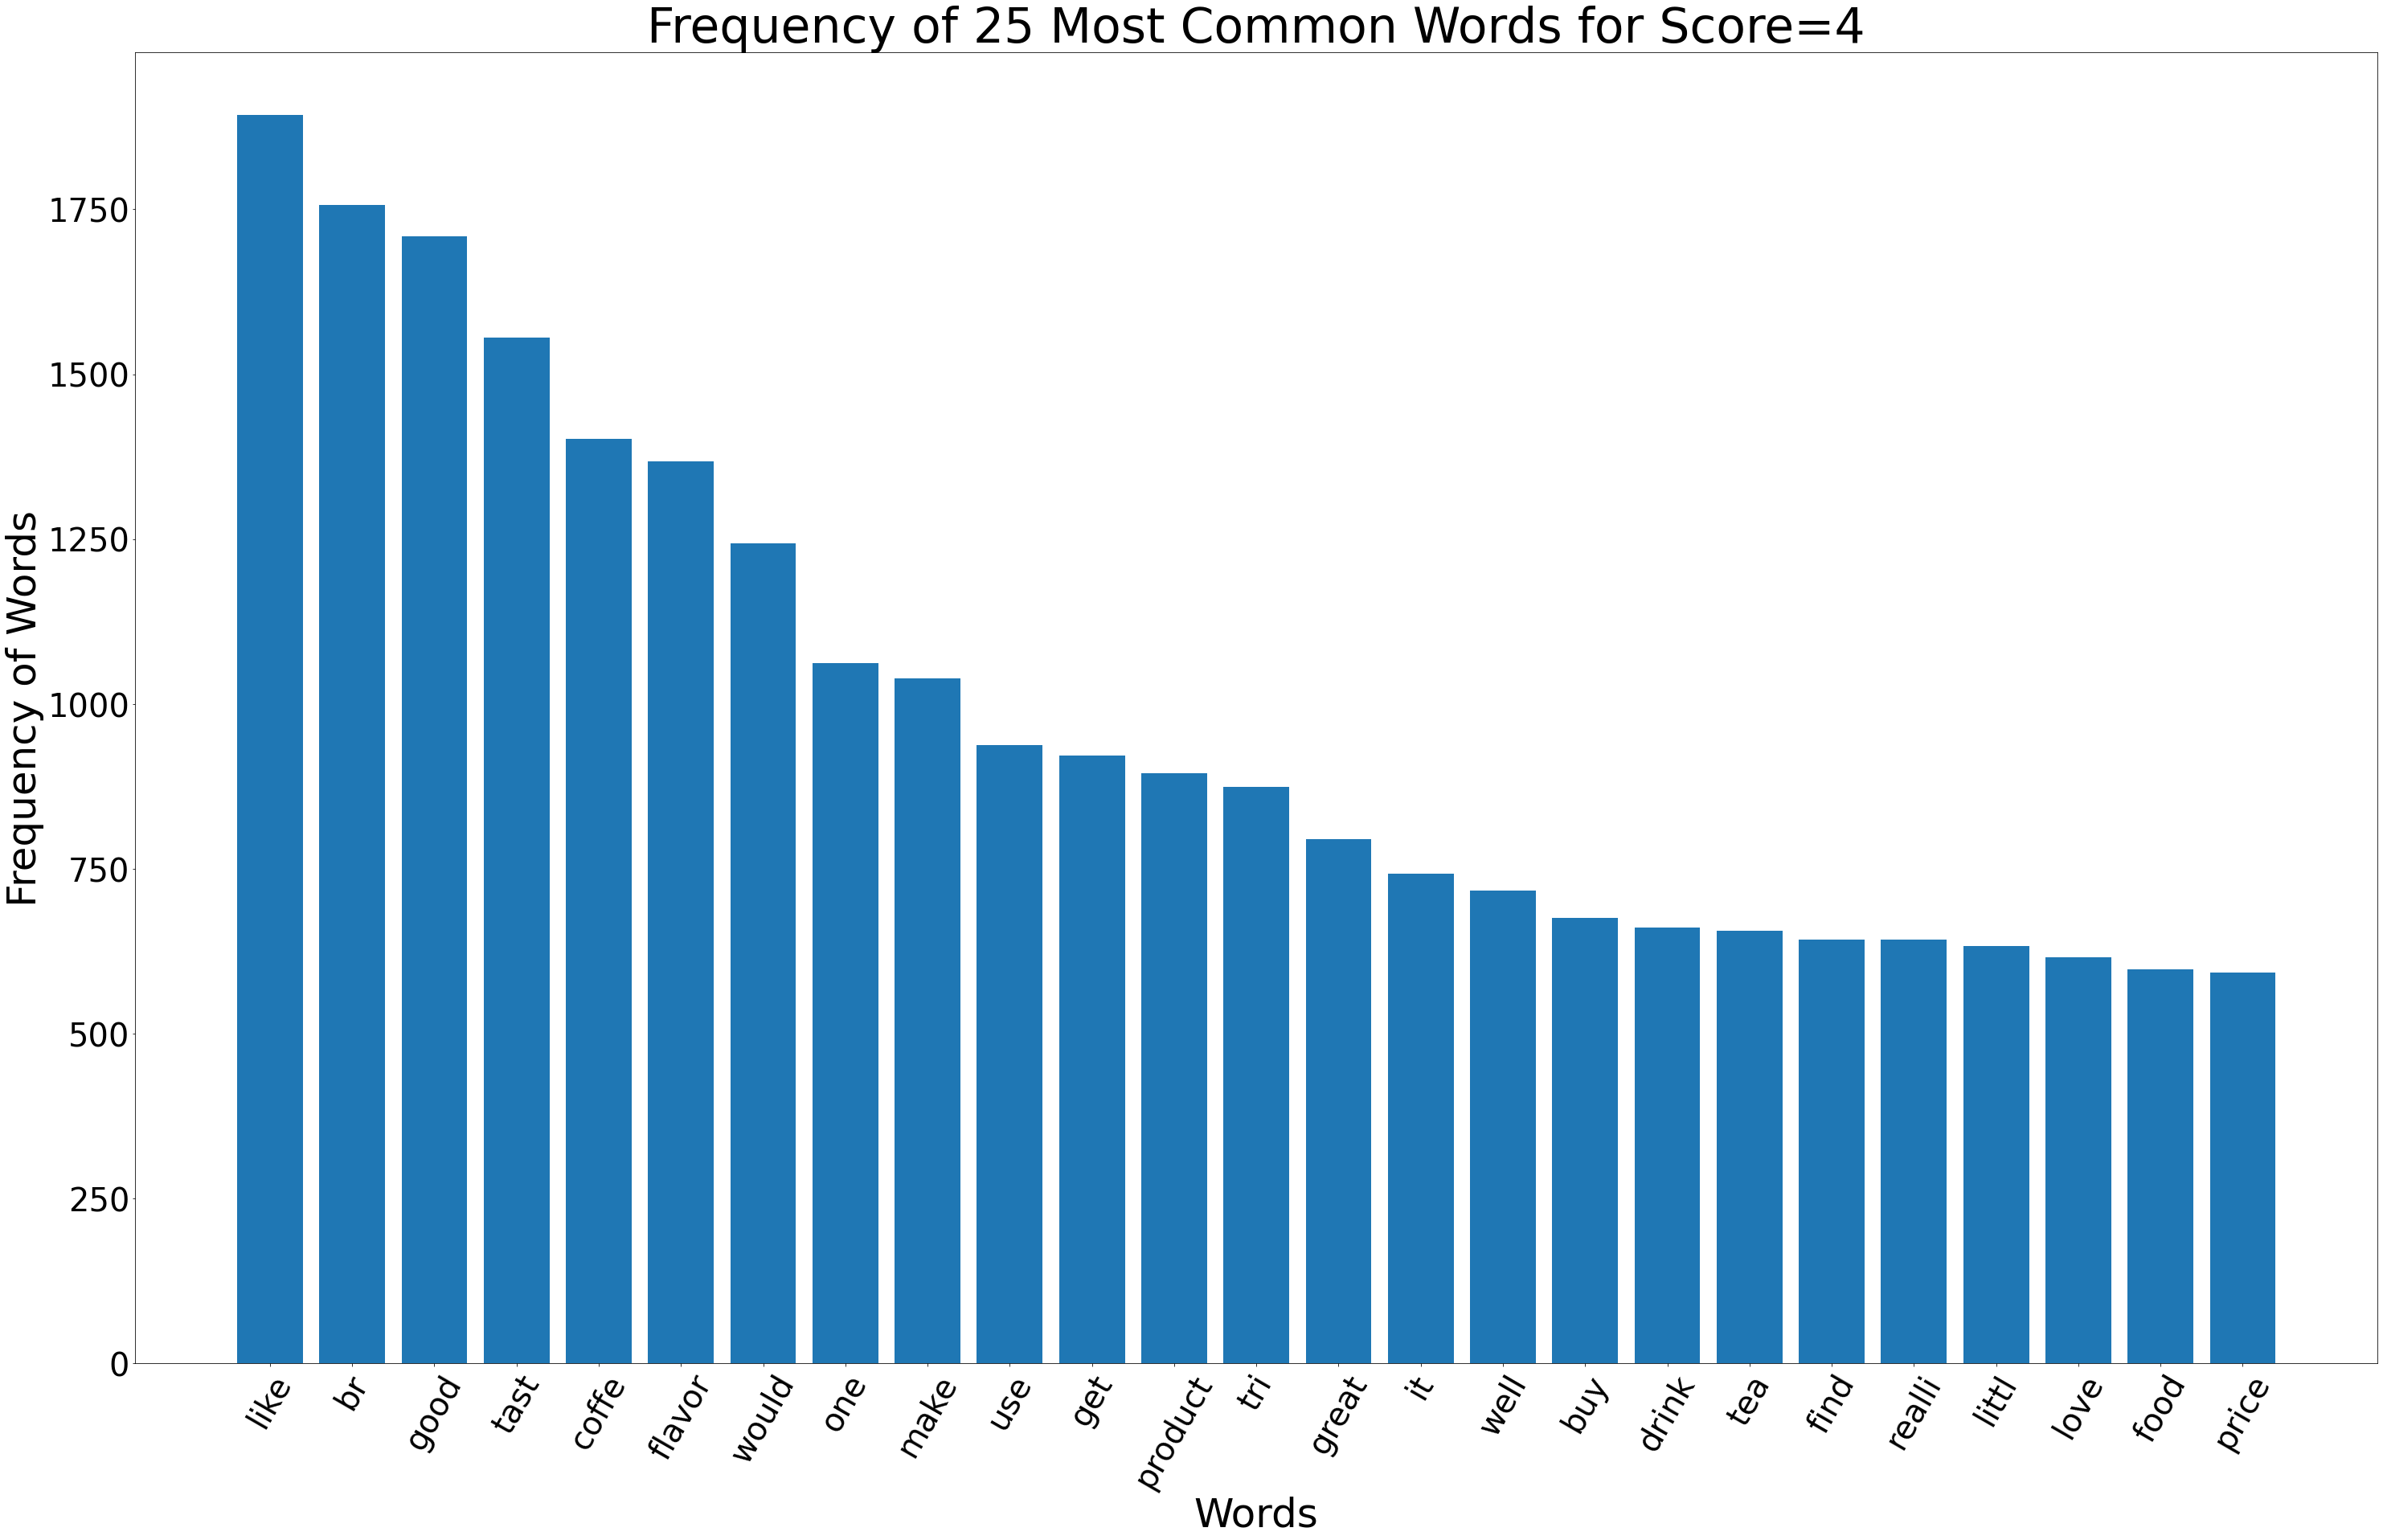

In [24]:
group_by_3 = group_by.iloc[3]
words3 = list(zip(*group_by_3))[0]
freq3 = list(zip(*group_by_3))[1]
plt.figure(figsize=(50,30))
plt.bar(words3, freq3)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=4', fontsize=60)
plt.show()

Dla Score 4 duża ilość jest słów :
- like
- good
- taste
- coffe
- flavor

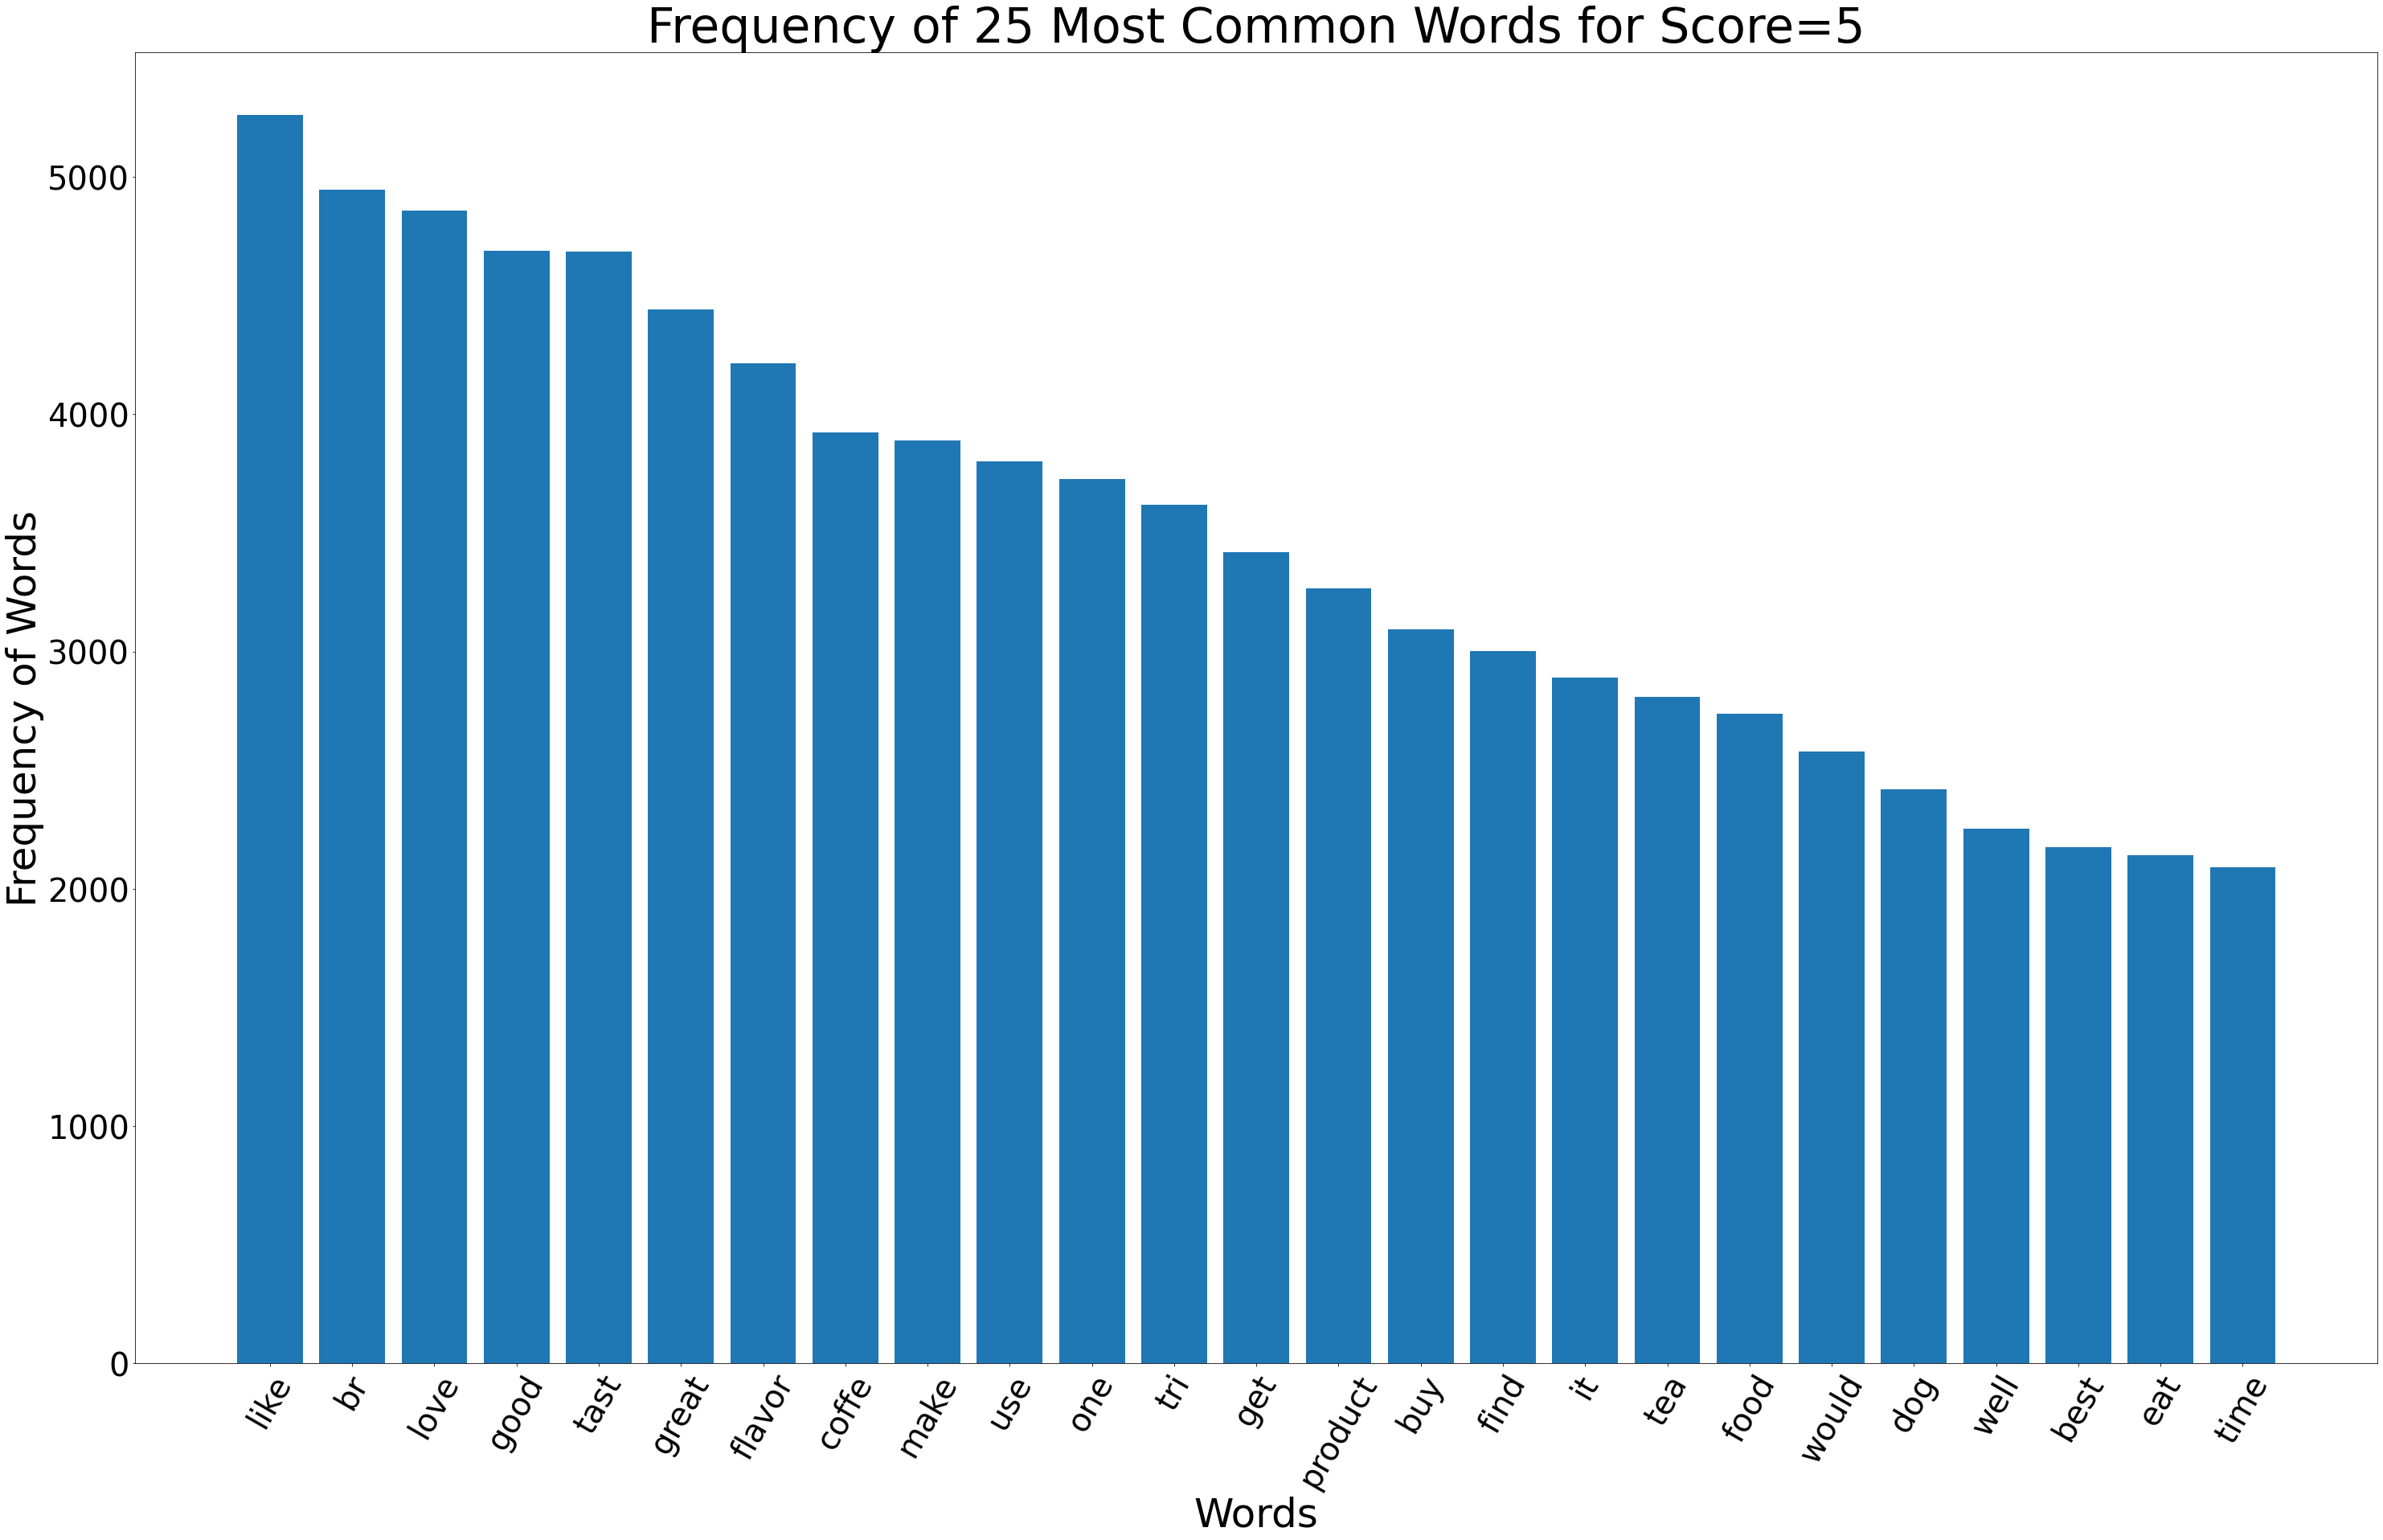

In [25]:
group_by_4 = group_by.iloc[4]
words4 = list(zip(*group_by_4))[0]
freq4 = list(zip(*group_by_4))[1]
plt.figure(figsize=(50,30))
plt.bar(words4, freq4)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for Score=5', fontsize=60)
plt.show()

Dla Score 5 duża ilość jest słów :
- like
- love
- good
- taste
- great
- flavor

### Klasyfikatory
- Naive Bayes Accuracy
- SVM

In [26]:
data = df_data
data.shape
data.head()

Score                                          lemma_str
0      5  buy sever vital can dog food product find good...
1      1  product arriv label jumbo salt peanutsth peanu...
2      4  confect around centuri light pillowi citrus ge...
3      2  look secret ingredi robitussin believ find it ...
4      5  great taffi great price wide assort yummi taff...

In [27]:
from sklearn import model_selection, naive_bayes, svm

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['lemma_str'],data['Score'],test_size=0.3)

In [28]:
from sklearn.preprocessing import LabelEncoder

# Encoder = LabelEncoder
# Train_Y = Encoder.fit_transform(Train_Y)
# Test_Y = Encoder.fit_transform(Test_Y)

In [29]:
Tfidf_vect = TfidfVectorizer(max_features=30000)
Tfidf_vect.fit(data['lemma_str'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [30]:
from sklearn.metrics import accuracy_score

# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  63.33333333333333


In [31]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  69.95


### Generowanie tematów opinii

W tym przypadku wypróbowanu metodę Non-Negative Matrix Factorization (NMF).

Metoda ta pomaga zmniejszyć wagę/wpływ słów o wysokiej częstotliwości czyli np. like, taste

Info :
- Na początku tworzymy obiekt vectorizer.
- Max_df = 0.9 usunie słowa które pojawiają się w ponad 90% opiniach.
- Min_df = 25 usunie słowa, które pojawiają się w mniej niż 25 opiniach.


In [32]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(df['lemma_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


1st   2g  2nd  3oz  3rd  4th  8oz  abil  abl  about  ...   yr  yuban  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
...    ...  ...  ...  ...  ...  ...  ...   ...  ...    ...  ...  ...    ...   
19995  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
19996  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
19997  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
19998  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   
19999  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...  0.0    0.0   

       yuck  yum     yummi  zealand  zero  zip  ziplock  zuke  
0       0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
1       0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
2       0.0  0.0  0.185343      0.0   0.0  0.0      0.0   0.0  
3       0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
4       0.0  0.0  0.330149      0.0   0.0  0.0      0.0   0.0  
...     ...  ...       ...      ...   ...  ...      ...   ...  
19995   0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
19996   0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
19997   0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
19998   0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  
19999   0.0  0.0  0.000000      0.0   0.0  0.0      0.0   0.0  

[20000 rows x 2471 columns]

In [34]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
no_top_words = 10

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(nmf, tfidf_feature_names, no_top_words)

E:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


Topic 0:
br like make use good tast one tri would mix
Topic 1:
coffe cup flavor kcup strong blend bold roast bitter smooth
Topic 2:
tea green grey earl ice drink flavor bag black tast
Topic 3:
dog treat love them give small train newman break organ
Topic 4:
drink juic soda carbon sugar flavor orang tast switch sweet
Topic 5:
chip flavor bag salt potato snack kettl love them great
Topic 6:
peanut butter fat calori tast great pb2 love mix powder
Topic 7:
product price great order amazon store find buy ship local
Topic 8:
food cat eat babi love it old dog feed year
Topic 9:
chocol hot cooki cocoa best milk dark bar tast kcup


E:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Tematy stworzone przez NMF oraz ich interpetacja :
- Temat 0 - Good mix taste
- Temat 1 - Strong blend cup of coffe
- Temat 2 - Green and gray tea
- Temat 3 - Dogs treats
- Temat 4 - Soda juice sweet flavor of orange
- Temat 5 - Bag of chips with flavor salt
- Temat 6 - Peanut butter
- Temat 7 - Great product prize and grat order
- Temat 8 - Food for cats ?
- Temat 9 - Good sweetness

In [39]:
nmf_topic_values = nmf.transform(tfidf) 
df['nmf_topics'] = nmf_topic_values.argmax(axis = 1)

nmf_remap = {0: 'Good mix taste', 1: 'Strong blend cup of coffe', 2: 'Green and gray tea', 3: 'Dogs treats', 
             4: 'Soda juice sweet flavor of orange', 5: 'Bag of chips with flavor salt', 6: 'Peanut butter', 7: 'Great product prize and grat order', 
             8: 'Food for cats ?', 9: 'Good sweetness'}
df['nmf_topics'] = df['nmf_topics'].map(nmf_remap)

E:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

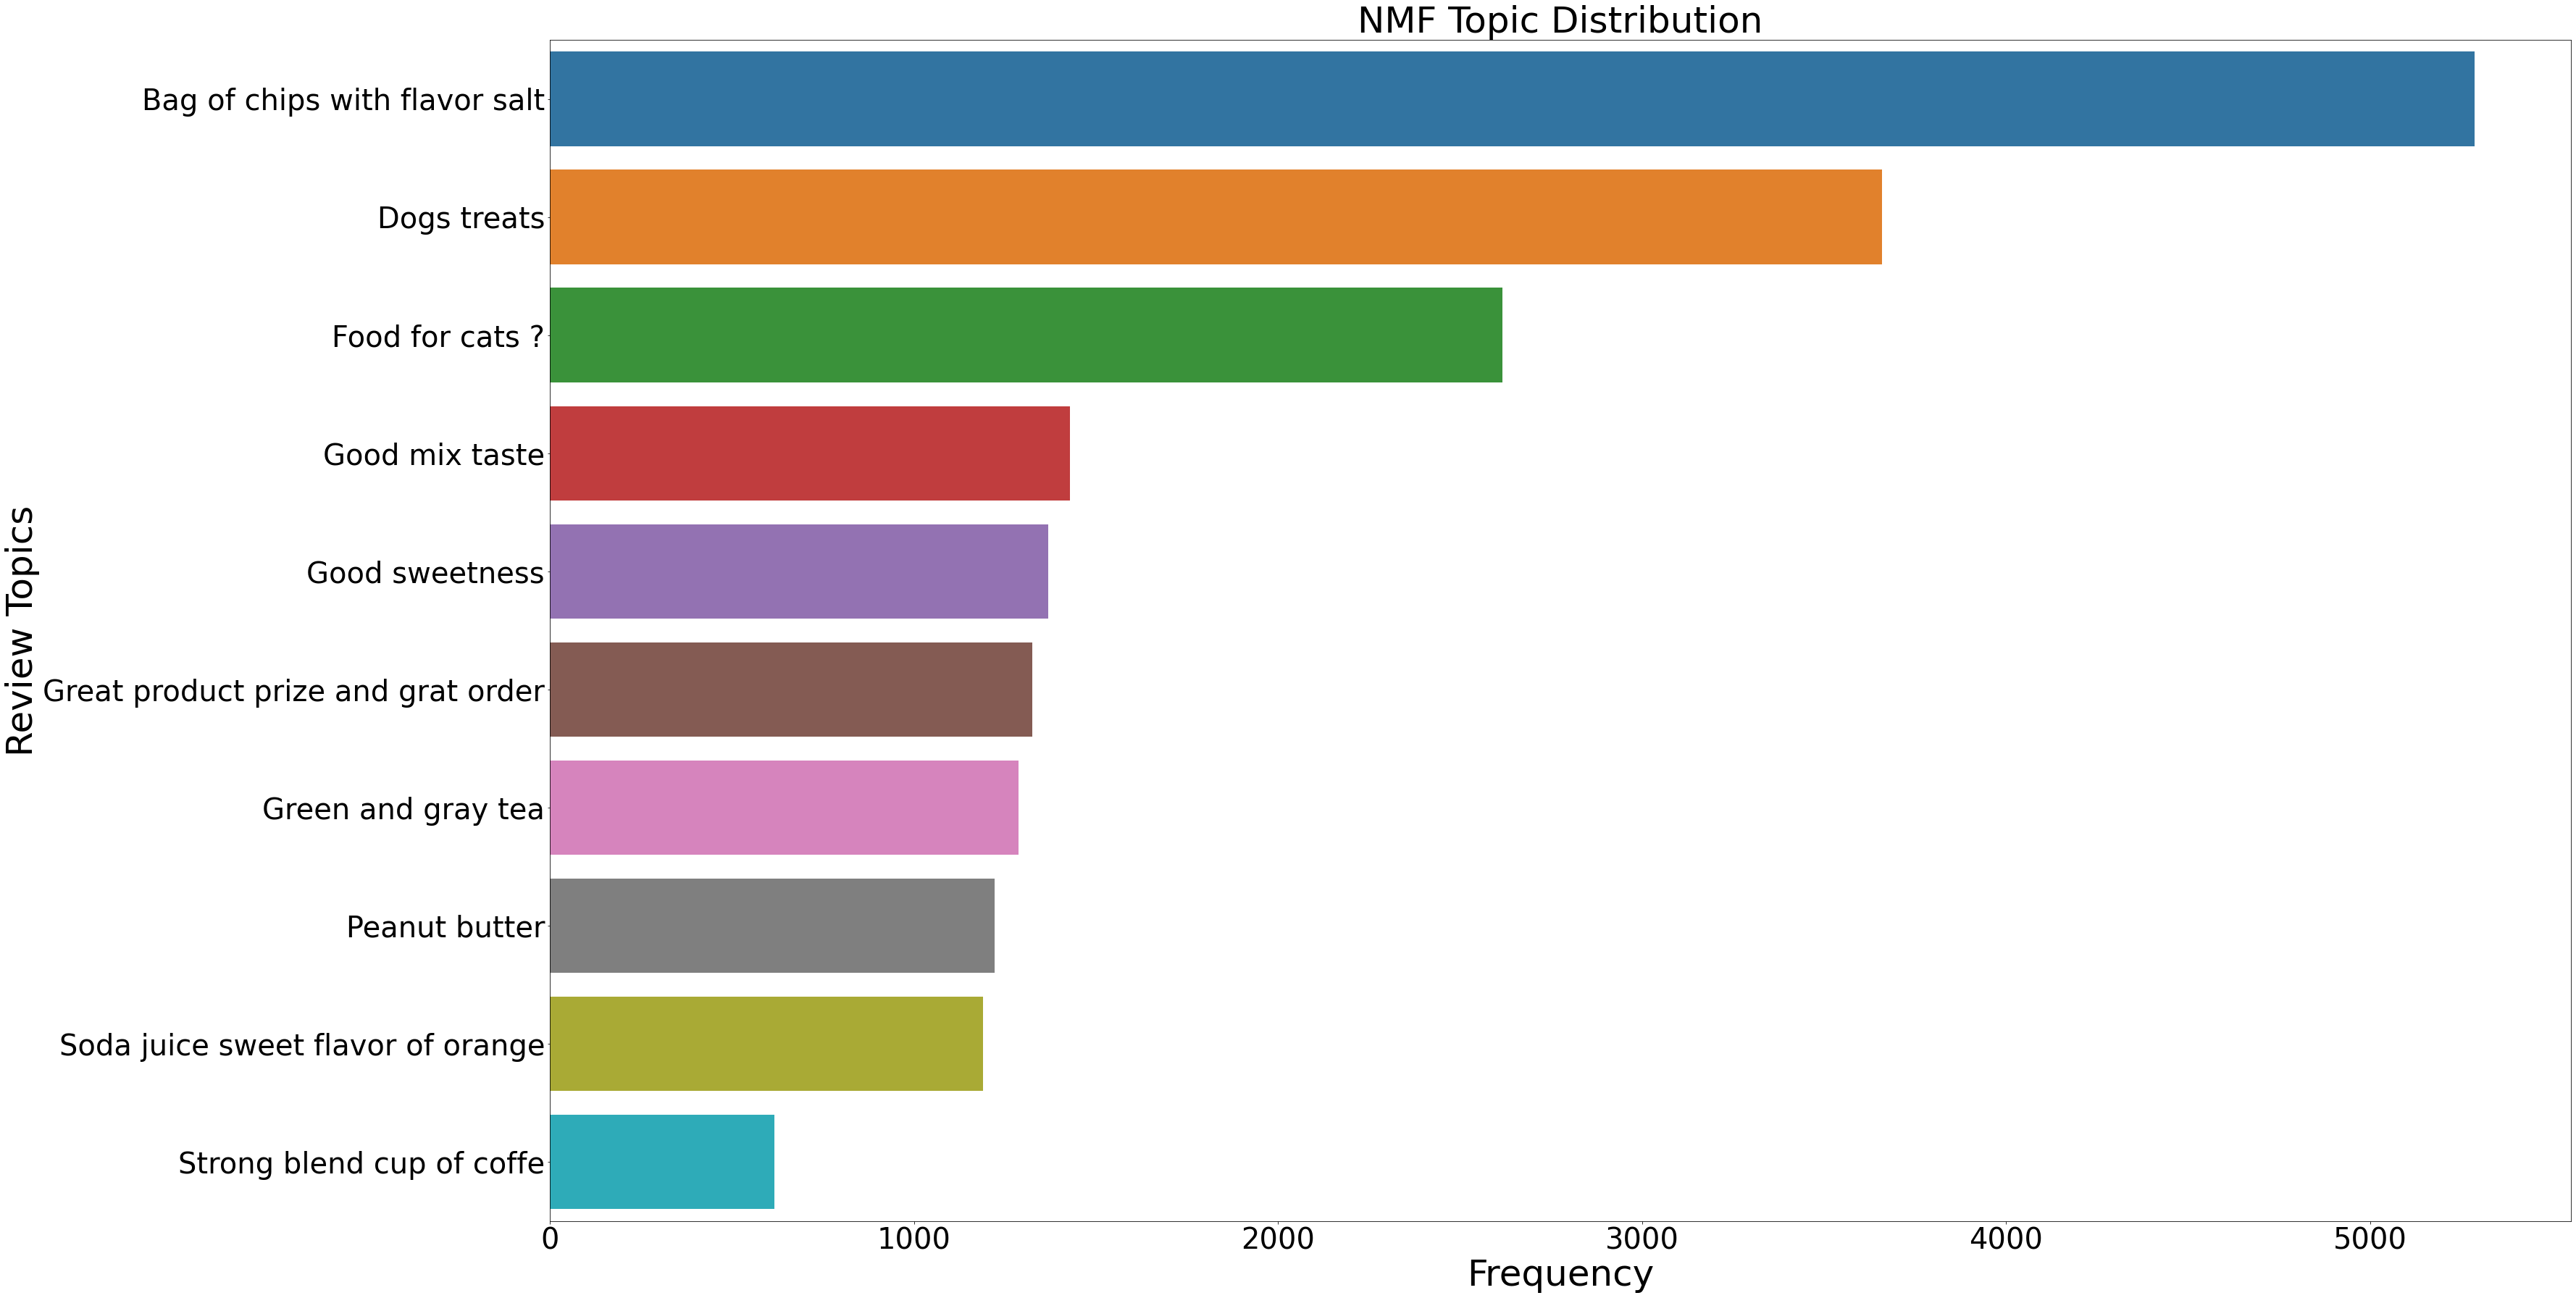

In [40]:
nmf_x = df['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

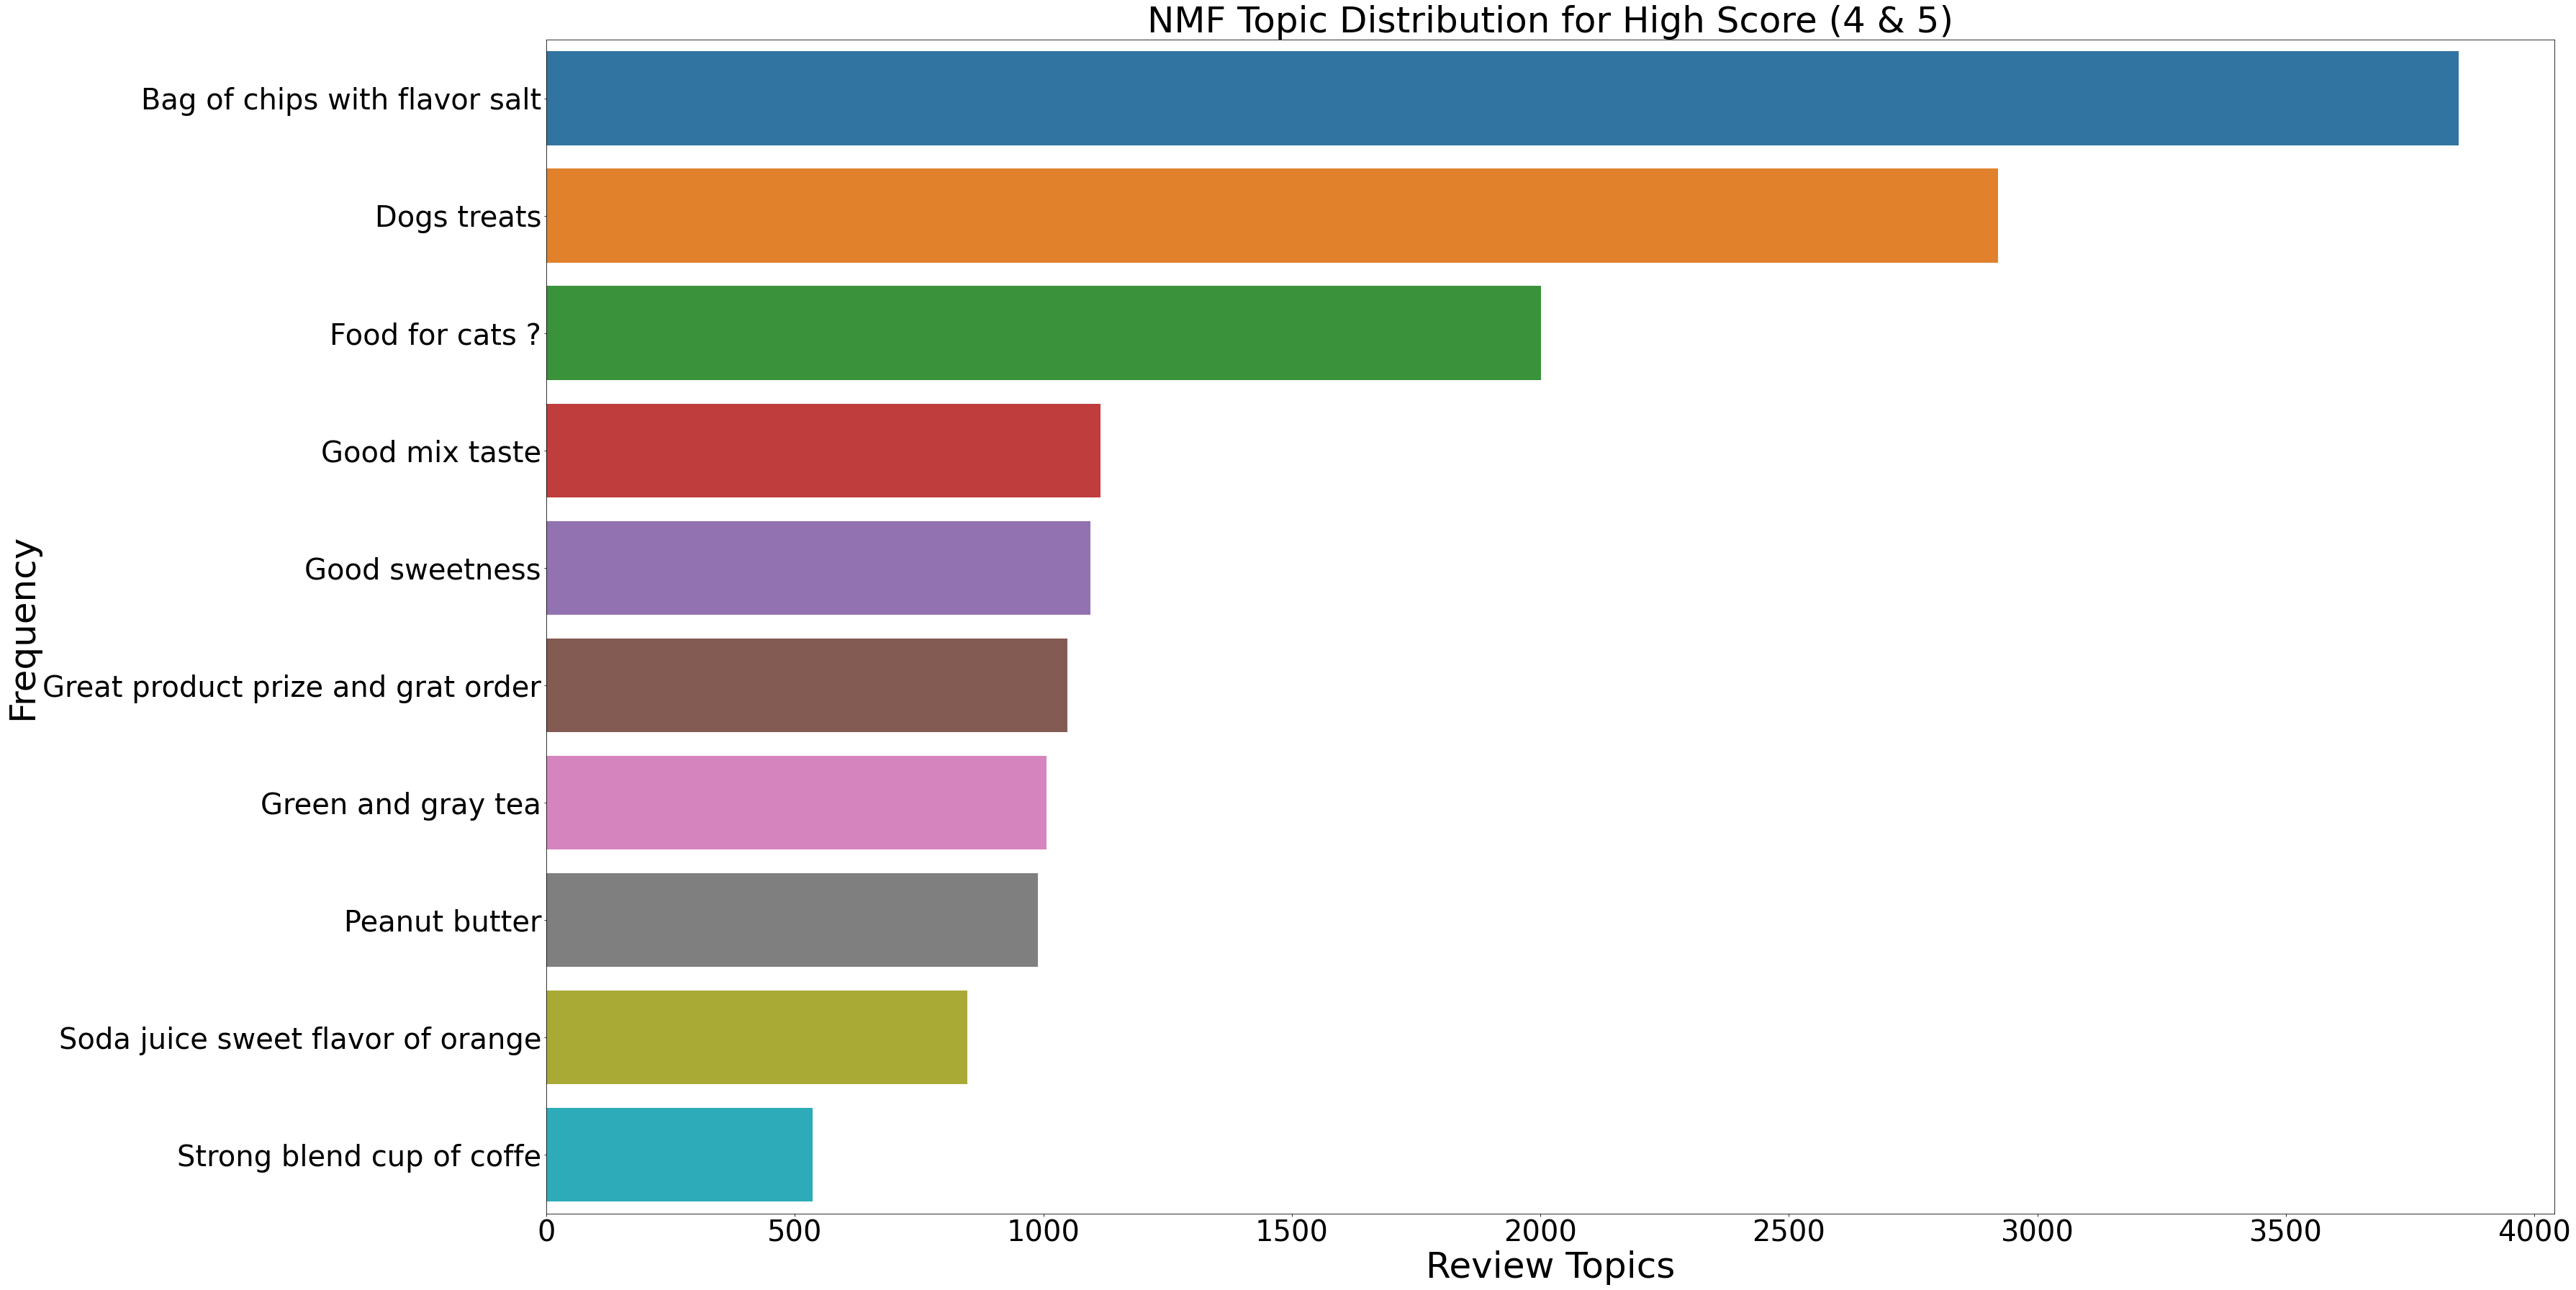

In [45]:
df_high_score = df.loc[(df['Score']==4) | (df['Score']==5)]
nmf_high_x = df_high_ratings['nmf_topics'].value_counts()
nmf_high_y = nmf_high_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_high_x, nmf_high_y.index)
plt.title("NMF Topic Distribution for High Score (4 & 5)", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

E:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

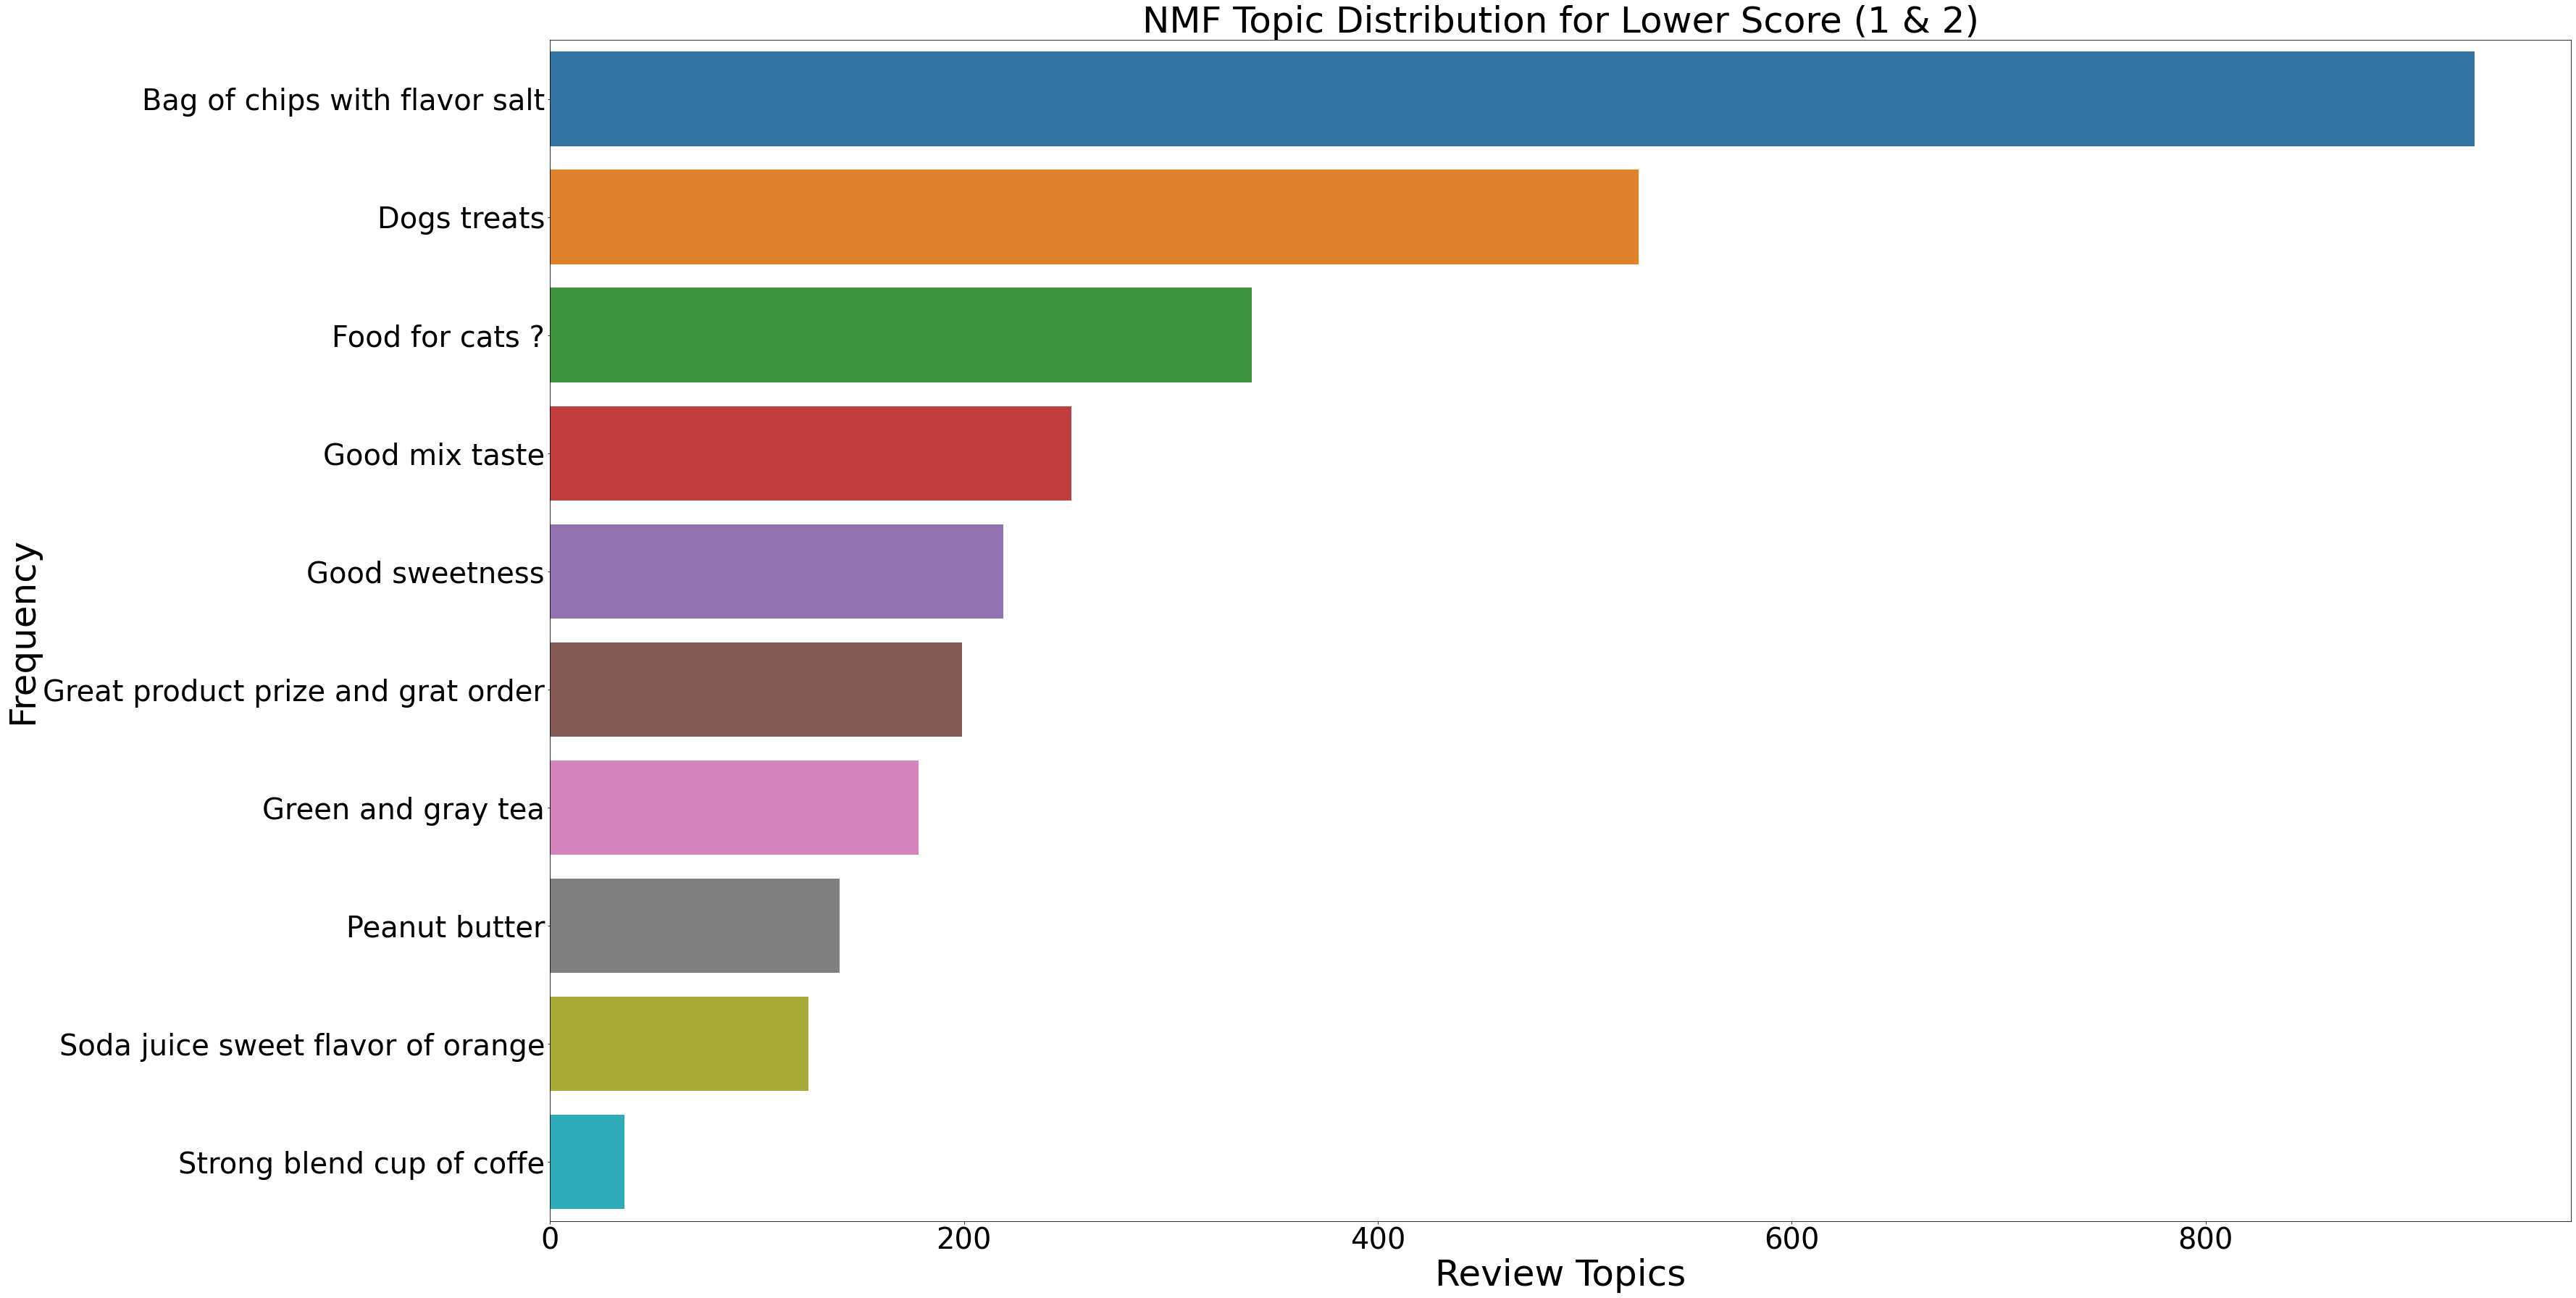

In [49]:
df_lower_score = df.loc[(df['Score']==1) | (df['Score']==2)]
nmf_lower_x = df_lower_score['nmf_topics'].value_counts()
nmf_lower_y = nmf_lower_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_lower_x, nmf_lower_y.index)
plt.title("NMF Topic Distribution for Lower Score (1 & 2)", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

### Konkluzja

- Z otrzymanych wyników widzimy że większość a raczej znaczna większość to opinie pozytywne
- Widzimy pozytywny rozkład gdzie 77 % użytkoników dało ocenę 4 lub 5.
- Analiza nastrojów potwierdziła te wyniki.
- Odnośnie tematów dla opinii negatywnych oraz pozytywnych jak widzimy powyżej trudno określić który temat bardziej się zalicza do jednej z tych dwóch grup ponieważ dane te to znaczna większość pozytywnych opinii nad negatywnymi.